This script can be used to do preprocessing of the fundus images from different databases. The images can have different formats as an input to the preprocessing functions and will eventually be turned into numpy arrays and stored in this format.

For every database a train and test numpy array is generated together with a numpy array containing the corresponding annotation files for training and testing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from skimage.transform import resize
import pandas as pd
from sklearn.model_selection import train_test_split
from resizeimage import resizeimage
import cv2

The functions below can be used to turn every image into a numpy array and to do preprocessing of the images. The preprocessing function at the end brings all preprocessing steps for one image together.

In [2]:
def PlotImage(image_array, database = '', image_name = '', save = False, savepath = ''):
    '''Visualize (and save if desired) an image represented by a numpy array'''
    
    plt.figure()
    plt.title(database+': '+image_name)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.imshow(image_array, cmap=plt.cm.Greys_r)
    
    if save == True:
        plt.savefig(savepath+database+'_'+image_name+'.png')
    
    return 

In [3]:
def LoadImage(filepath, plot = False, data_base = '', annotation = False):
    '''Load an image indicated by the filepath and turn it into a numpy array'''
    im = Image.open(filepath)
    im_array = np.asarray(im)
    
    if plot == True:
        if annotation == True:
            PlotImage(im_array, database = data_base, image_name = 'Annotation')
            PlotImage(im_array, database = data_base, image_name = 'Image')
    
    return im_array

In [4]:
def SelectChannel(image_array, color, plot = False, data_base = ''):
    '''
    For the segmentation of some lesions a particular color channel should be selected
    The possible options for color are 'R', 'G' or 'B'.
    '''
    
    if color == 'R':
        color_channel = image_array[:,:,0]
    
    elif color == 'G':
        color_channel = image_array[:,:,1]
    
    elif color == 'B':
        color_channel = image_array[:,:,2]
        
    else:
        return 'Not a valid color channel!'
    
    if plot == True:
        PlotImage(color_channel, database = data_base, image_name = 'Color Channnel '+ color)
    
    return color_channel

In [5]:
def FindMask(image_array, plot = False, data_base = ''):
    '''
    defining a binary mask that delineates the retina on the image
    simple thresholding is used for this procedure
    '''
    mask = np.zeros(image_array.shape[0:2])
    
    # in the red channel the difference between background and retina is the largest
    # a threshold of 50 is used, as defined from the histogram below
    red_channel = SelectChannel(image_array, 'R')
    
    # linear contrast mapping is performed when the full intensity range is not used
    intensity_range = np.unique(red_channel)
    if intensity_range[0]!= 0 or intensity_range[-1]!= 255:
        red_channel = cv2.normalize(red_channel, np.zeros(red_channel.shape), alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)

    retina_positions = np.where(red_channel > 25)
    mask[retina_positions] = 1
    
    if plot == True:
        PlotImage(mask, database = data_base, image_name = 'Retinal Mask')
    
    return mask

In [6]:
def Cropping(image_array, mask, annotation = False, plot = False, data_base = ''):
    '''
    crop the image according to the found mask
    the smallest bounding box around the retina (as delineated by the mask) is defined
    and the image is cropped to this bounding box
    '''
    
    # define the smallest bounding box around the retina according to the mask
    # define whether there is any value different from 0 on every row and column
    non_zero_row = np.any(mask, axis = 1) # returns a list of true and false
    non_zero_col = np.any(mask, axis = 0)
    
    # define the indiced of the non-zero rows and cols
    non_zero_row_indices = np.where(non_zero_row)[0]
    non_zero_col_indices = np.where(non_zero_col)[0]
    
    # define the indices of the first and last col and row that contain a non-zero value
    lbox = non_zero_col_indices[0]
    rbox = non_zero_col_indices[-1]
    ubox = non_zero_row_indices[0]
    dbox = non_zero_row_indices[-1]
    
    if lbox >= rbox or ubox >= dbox:
        print('Smallest bounding box can not be defined!')
       
    # crop the image and annotation file according to the bounding box
    # in case of an annotation there is only 1 channel
    if annotation:
        cropped_image_array = image_array[ubox:dbox+1, lbox:rbox+1]
        if plot == True:
            PlotImage(cropped_image_array, database = data_base, image_name = 'Cropped Annotation')
        return cropped_image_array
        
    cropped_image_array = image_array[ubox:dbox+1, lbox:rbox+1, :]
    if plot == True:
        PlotImage(cropped_image_array, database = data_base, image_name = 'Cropped Image')
    return cropped_image_array

In [7]:
def Resizing(image_array, desired_size, plot = False, data_base = '', annotation = False):
    '''Resize the images to the desired shape that is used as an input to the neural network'''
    
    # resizing the image to the desired shape
    image = Image.fromarray(image_array)
    resized_image = resizeimage.resize_cover(image, [desired_size, desired_size], validate=False)
    resized_image_array = np.asarray(resized_image)
    
    if plot == True:
        if annotation == True:
            PlotImage(resized_image_array, database = data_base, image_name = 'Resized Annotation')
        else:
            PlotImage(resized_image_array, database = data_base, image_name = 'Resized Image')
    
    return resized_image_array  

In [8]:
def HistogramEqualization(im_array, plot = False, data_base = ''):
    '''
    This function performs historgram equalization in a local way
    It improves the contrast and it makes the image illumination more uniform
    '''
    clahe = cv2.createCLAHE(clipLimit= 2.0, tileGridSize=(4,4))
    
    x = len(im_array.shape)
    
    if x == 3:
        red_channel = clahe.apply(im_array[:, :, 0])
        green_channel = clahe.apply(im_array[:, :, 1])
        blue_channel = clahe.apply(im_array[:, :, 2])
        equalized_im_array = np.dstack((red_channel, green_channel, blue_channel))
        
    elif x == 2:
        equalized_im_array = clahe.apply(im_array)
        
    if plot == True:
        PlotImage(equalized_im_array, database = data_base, image_name = 'Histogram Equalized Image')
        
    return equalized_im_array   

In [9]:
def Preprocessing(FilePathImage, DesiredSize, FilePathAnnotation = None, selectchannel = None, Plot = False, DataBase = ''):
    '''
    This function preprocesses the image that is found at the given FilePath
    In case there is an annotation image, the path of this annotations should be indicated and
    this annotation image is also preprocessed
    If a channel should be selected selectchannel should have a value of 'R', 'G' or 'B'
    '''
    
    # read in the image and turn into a numpy array
    image_array = LoadImage(FilePathImage, plot = Plot, data_base = DataBase)
    
    # define a binary mask indicating the location of the retina on the image
    mask = FindMask(image_array, plot = Plot, data_base = DataBase)
    
    # crop the image according to the mask 
    cropped_image_array = Cropping(image_array, mask, plot = Plot, data_base = DataBase)
    
    # resize the image according to the predefined size
    resized_image_array = Resizing(cropped_image_array, desired_size = DesiredSize, plot = Plot, data_base = DataBase)

    if selectchannel:
        resized_image_array = SelectChannel(resized_image_array, color = selectchannel, plot = Plot, data_base = DataBase)
        
    # histogram equalization of the image
    resized_image_array_equal = HistogramEqualization(resized_image_array, plot = Plot, data_base = DataBase)
    
    resized_image_array_final = np.expand_dims(resized_image_array_equal, axis = 0)   
    
    # apply the same processing to the corresponding annotation file (if present)
    if FilePathAnnotation:
        annotation_array = LoadImage(FilePathAnnotation, plot = Plot, data_base = DataBase, annotation = True)
        cropped_annotation_array = Cropping(annotation_array, mask, annotation = True, plot = Plot, data_base = DataBase) # same mask as the image
        resized_annotation_array = Resizing(cropped_annotation_array, desired_size = DesiredSize, plot = Plot, data_base = DataBase, annotation = True)
        resized_annotation_array_final = np.expand_dims(resized_annotation_array, axis = 0)
        return resized_image_array_final, resized_annotation_array_final
        

    return resized_image_array_final

For every database the path for all images (and annotations) now has to be defined such that all images and annotations can be preprocessed and the resulting numpy arrays can be gathered together into training and testing arrays.

In [10]:
# Define the DataBase you want to preprocess, image and annotation formats are different for different databases

# Kaggle, DR grades
DataBase = 'Kaggle'

In [11]:
# size to which the images should be resized, here 512 x 512 is chosen
image_size = 256

In [12]:
def DataPath(database, lesiontype = None):
    '''define the datapath corresponding to the used database'''
    
    print('Defining the data path for the database...')
    datapath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/' + database + '/'
    
    if lesiontype:
        datapath = datapath + lesiontype + '/'
    
    print('Data path: {}'.format(datapath))
    return datapath

In [13]:
def FileFormat(database):
    '''Depending on the database, the image and annotation format can be different'''
    
    print('Defining file formats...')
    
    if database == 'IDRiD':
        image_format = '.jpg'
        annotation_format = '.tif'
        
    elif database == 'DRIVE':
        image_format = '.tif'
        annotation_format = '.png'
        
    elif database == 'STARE':
        image_format = '.ppm'
        annotation_format = '.ppm'
        
    elif database == 'CHASEDB1':
        image_format = '.jpg'
        annotation_format = '.png'
        
    elif database == 'Kaggle':
        image_format = '.jpeg'
        # in this case there are no annotations but labels
        annotation_format = None
        
    print('Image format: {}, Annotation_format: {}'.format(image_format, annotation_format))
    return image_format, annotation_format

In [14]:
def FilePathList(datapath, fileformat):
    '''define a list of the filepaths of the files found in the datapath'''
    
    print('Defining all file paths...')
    filepath_list = glob(datapath + '*' + fileformat)
    
    return filepath_list

In [15]:
def ArraysImagesLabels(database, ImageSize):
    '''
    This function takes all test and train images and corresponding labels,
    turns them into numpy arrays, preprocesses them and saves them as numpy arrays
    '''
    
    # base datapath of the database
    datapath = DataPath(database)
    
    # path for the images
    path_images = datapath + '/' + 'images' + '/'
    
    # format of the images
    image_format, _ = FileFormat(database)
    
    # define list of all file paths of all images
    path_list_images = FilePathList(path_images, image_format)
    
    # print out the amount of images
    print('Total amount of images: {}'.format(len(path_list_images)))
    
    # go over all images, preprocess them and store them in arrays
    for file_number in range(len(path_list_images)):
        print('Preprocessing image file {}'.format(file_number+1))
        im_path = path_list_images[file_number]
    
        prep_im_array = Preprocessing(im_path, ImageSize)
        
        if file_number == 0:
            im_array = prep_im_array
        else:
            im_array = np.vstack((im_array, prep_im_array))
    
    print('Size of the total image array: {}'.format(im_array.shape))
    
    # load the labels from the csv file
    labels = pd.read_csv(datapath + 'labels.csv')
    # drop the column with image names, we only want the labels
    labels = labels.drop(columns = ['image'])
    # turn labels into a numpy array
    labels = labels.to_numpy()
    labels.flatten()
    labels_array = labels[:,0]
    
    # turn the labels into binary label indicating whether the pathology is more than mild or not
    # everythin higher than 1 is more than mild
    new_labels_array = np.zeros(labels_array.shape)
    more_than_mild_positions = np.where(labels_array >1)
    new_labels_array[more_than_mild_positions] = 1
    
    # one-hot encoding of the labels
    final_labels_array = np.zeros((labels_array.shape[0], 2))

    for position in range(labels_array.shape[0]):
        # (1,0) = more than mild
        if new_labels_array[position] == 1:
            final_labels_array[position,:] = [1,0]
        else:
            final_labels_array[position,:] = [0,1]
    
    print('Size of the total labels array: {}'.format(final_labels_array.shape))  
    
    # save the image and label arrays
    print('Saving the image and label array...')
    np.save(datapath + 'Arrays/' + 'total_images.npy', im_array)
    np.save(datapath + 'Arrays/' + 'total_labels.npy', final_labels_array)
    
    print('Done')


In [16]:
ArraysImagesLabels(DataBase, ImageSize = image_size)

Defining the data path for the database...
Data path: C:/Users/lunam/Documents/1steMaster/Stage/Data/Kaggle/
Defining file formats...
Image format: .jpeg, Annotation_format: None
Defining all file paths...
Total amount of images: 35126
Preprocessing image file 1
Preprocessing image file 2
Preprocessing image file 3
Preprocessing image file 4
Preprocessing image file 5
Preprocessing image file 6
Preprocessing image file 7
Preprocessing image file 8
Preprocessing image file 9
Preprocessing image file 10
Preprocessing image file 11
Preprocessing image file 12
Preprocessing image file 13
Preprocessing image file 14
Preprocessing image file 15
Preprocessing image file 16
Preprocessing image file 17
Preprocessing image file 18
Preprocessing image file 19
Preprocessing image file 20
Preprocessing image file 21
Preprocessing image file 22
Preprocessing image file 23
Preprocessing image file 24
Preprocessing image file 25
Preprocessing image file 26
Preprocessing image file 27
Preprocessing ima

Preprocessing image file 280
Preprocessing image file 281
Preprocessing image file 282
Preprocessing image file 283
Preprocessing image file 284
Preprocessing image file 285
Preprocessing image file 286
Preprocessing image file 287
Preprocessing image file 288
Preprocessing image file 289
Preprocessing image file 290
Preprocessing image file 291
Preprocessing image file 292
Preprocessing image file 293
Preprocessing image file 294
Preprocessing image file 295
Preprocessing image file 296
Preprocessing image file 297
Preprocessing image file 298
Preprocessing image file 299
Preprocessing image file 300
Preprocessing image file 301
Preprocessing image file 302
Preprocessing image file 303
Preprocessing image file 304
Preprocessing image file 305
Preprocessing image file 306
Preprocessing image file 307
Preprocessing image file 308
Preprocessing image file 309
Preprocessing image file 310
Preprocessing image file 311
Preprocessing image file 312
Preprocessing image file 313
Preprocessing 

Preprocessing image file 563
Preprocessing image file 564
Preprocessing image file 565
Preprocessing image file 566
Preprocessing image file 567
Preprocessing image file 568
Preprocessing image file 569
Preprocessing image file 570
Preprocessing image file 571
Preprocessing image file 572
Preprocessing image file 573
Preprocessing image file 574
Preprocessing image file 575
Preprocessing image file 576
Preprocessing image file 577
Preprocessing image file 578
Preprocessing image file 579
Preprocessing image file 580
Preprocessing image file 581
Preprocessing image file 582
Preprocessing image file 583
Preprocessing image file 584
Preprocessing image file 585
Preprocessing image file 586
Preprocessing image file 587
Preprocessing image file 588
Preprocessing image file 589
Preprocessing image file 590
Preprocessing image file 591
Preprocessing image file 592
Preprocessing image file 593
Preprocessing image file 594
Preprocessing image file 595
Preprocessing image file 596
Preprocessing 

Preprocessing image file 846
Preprocessing image file 847
Preprocessing image file 848
Preprocessing image file 849
Preprocessing image file 850
Preprocessing image file 851
Preprocessing image file 852
Preprocessing image file 853
Preprocessing image file 854
Preprocessing image file 855
Preprocessing image file 856
Preprocessing image file 857
Preprocessing image file 858
Preprocessing image file 859
Preprocessing image file 860
Preprocessing image file 861
Preprocessing image file 862
Preprocessing image file 863
Preprocessing image file 864
Preprocessing image file 865
Preprocessing image file 866
Preprocessing image file 867
Preprocessing image file 868
Preprocessing image file 869
Preprocessing image file 870
Preprocessing image file 871
Preprocessing image file 872
Preprocessing image file 873
Preprocessing image file 874
Preprocessing image file 875
Preprocessing image file 876
Preprocessing image file 877
Preprocessing image file 878
Preprocessing image file 879
Preprocessing 

Preprocessing image file 1125
Preprocessing image file 1126
Preprocessing image file 1127
Preprocessing image file 1128
Preprocessing image file 1129
Preprocessing image file 1130
Preprocessing image file 1131
Preprocessing image file 1132
Preprocessing image file 1133
Preprocessing image file 1134
Preprocessing image file 1135
Preprocessing image file 1136
Preprocessing image file 1137
Preprocessing image file 1138
Preprocessing image file 1139
Preprocessing image file 1140
Preprocessing image file 1141
Preprocessing image file 1142
Preprocessing image file 1143
Preprocessing image file 1144
Preprocessing image file 1145
Preprocessing image file 1146
Preprocessing image file 1147
Preprocessing image file 1148
Preprocessing image file 1149
Preprocessing image file 1150
Preprocessing image file 1151
Preprocessing image file 1152
Preprocessing image file 1153
Preprocessing image file 1154
Preprocessing image file 1155
Preprocessing image file 1156
Preprocessing image file 1157
Preprocess

Preprocessing image file 1399
Preprocessing image file 1400
Preprocessing image file 1401
Preprocessing image file 1402
Preprocessing image file 1403
Preprocessing image file 1404
Preprocessing image file 1405
Preprocessing image file 1406
Preprocessing image file 1407
Preprocessing image file 1408
Preprocessing image file 1409
Preprocessing image file 1410
Preprocessing image file 1411
Preprocessing image file 1412
Preprocessing image file 1413
Preprocessing image file 1414
Preprocessing image file 1415
Preprocessing image file 1416
Preprocessing image file 1417
Preprocessing image file 1418
Preprocessing image file 1419
Preprocessing image file 1420
Preprocessing image file 1421
Preprocessing image file 1422
Preprocessing image file 1423
Preprocessing image file 1424
Preprocessing image file 1425
Preprocessing image file 1426
Preprocessing image file 1427
Preprocessing image file 1428
Preprocessing image file 1429
Preprocessing image file 1430
Preprocessing image file 1431
Preprocess

Preprocessing image file 1673
Preprocessing image file 1674
Preprocessing image file 1675
Preprocessing image file 1676
Preprocessing image file 1677
Preprocessing image file 1678
Preprocessing image file 1679
Preprocessing image file 1680
Preprocessing image file 1681
Preprocessing image file 1682
Preprocessing image file 1683
Preprocessing image file 1684
Preprocessing image file 1685
Preprocessing image file 1686
Preprocessing image file 1687
Preprocessing image file 1688
Preprocessing image file 1689
Preprocessing image file 1690
Preprocessing image file 1691
Preprocessing image file 1692
Preprocessing image file 1693
Preprocessing image file 1694
Preprocessing image file 1695
Preprocessing image file 1696
Preprocessing image file 1697
Preprocessing image file 1698
Preprocessing image file 1699
Preprocessing image file 1700
Preprocessing image file 1701
Preprocessing image file 1702
Preprocessing image file 1703
Preprocessing image file 1704
Preprocessing image file 1705
Preprocess

Preprocessing image file 1947
Preprocessing image file 1948
Preprocessing image file 1949
Preprocessing image file 1950
Preprocessing image file 1951
Preprocessing image file 1952
Preprocessing image file 1953
Preprocessing image file 1954
Preprocessing image file 1955
Preprocessing image file 1956
Preprocessing image file 1957
Preprocessing image file 1958
Preprocessing image file 1959
Preprocessing image file 1960
Preprocessing image file 1961
Preprocessing image file 1962
Preprocessing image file 1963
Preprocessing image file 1964
Preprocessing image file 1965
Preprocessing image file 1966
Preprocessing image file 1967
Preprocessing image file 1968
Preprocessing image file 1969
Preprocessing image file 1970
Preprocessing image file 1971
Preprocessing image file 1972
Preprocessing image file 1973
Preprocessing image file 1974
Preprocessing image file 1975
Preprocessing image file 1976
Preprocessing image file 1977
Preprocessing image file 1978
Preprocessing image file 1979
Preprocess

Preprocessing image file 2221
Preprocessing image file 2222
Preprocessing image file 2223
Preprocessing image file 2224
Preprocessing image file 2225
Preprocessing image file 2226
Preprocessing image file 2227
Preprocessing image file 2228
Preprocessing image file 2229
Preprocessing image file 2230
Preprocessing image file 2231
Preprocessing image file 2232
Preprocessing image file 2233
Preprocessing image file 2234
Preprocessing image file 2235
Preprocessing image file 2236
Preprocessing image file 2237
Preprocessing image file 2238
Preprocessing image file 2239
Preprocessing image file 2240
Preprocessing image file 2241
Preprocessing image file 2242
Preprocessing image file 2243
Preprocessing image file 2244
Preprocessing image file 2245
Preprocessing image file 2246
Preprocessing image file 2247
Preprocessing image file 2248
Preprocessing image file 2249
Preprocessing image file 2250
Preprocessing image file 2251
Preprocessing image file 2252
Preprocessing image file 2253
Preprocess

Preprocessing image file 2495
Preprocessing image file 2496
Preprocessing image file 2497
Preprocessing image file 2498
Preprocessing image file 2499
Preprocessing image file 2500
Preprocessing image file 2501
Preprocessing image file 2502
Preprocessing image file 2503
Preprocessing image file 2504
Preprocessing image file 2505
Preprocessing image file 2506
Preprocessing image file 2507
Preprocessing image file 2508
Preprocessing image file 2509
Preprocessing image file 2510
Preprocessing image file 2511
Preprocessing image file 2512
Preprocessing image file 2513
Preprocessing image file 2514
Preprocessing image file 2515
Preprocessing image file 2516
Preprocessing image file 2517
Preprocessing image file 2518
Preprocessing image file 2519
Preprocessing image file 2520
Preprocessing image file 2521
Preprocessing image file 2522
Preprocessing image file 2523
Preprocessing image file 2524
Preprocessing image file 2525
Preprocessing image file 2526
Preprocessing image file 2527
Preprocess

Preprocessing image file 2769
Preprocessing image file 2770
Preprocessing image file 2771
Preprocessing image file 2772
Preprocessing image file 2773
Preprocessing image file 2774
Preprocessing image file 2775
Preprocessing image file 2776
Preprocessing image file 2777
Preprocessing image file 2778
Preprocessing image file 2779
Preprocessing image file 2780
Preprocessing image file 2781
Preprocessing image file 2782
Preprocessing image file 2783
Preprocessing image file 2784
Preprocessing image file 2785
Preprocessing image file 2786
Preprocessing image file 2787
Preprocessing image file 2788
Preprocessing image file 2789
Preprocessing image file 2790
Preprocessing image file 2791
Preprocessing image file 2792
Preprocessing image file 2793
Preprocessing image file 2794
Preprocessing image file 2795
Preprocessing image file 2796
Preprocessing image file 2797
Preprocessing image file 2798
Preprocessing image file 2799
Preprocessing image file 2800
Preprocessing image file 2801
Preprocess

Preprocessing image file 3043
Preprocessing image file 3044
Preprocessing image file 3045
Preprocessing image file 3046
Preprocessing image file 3047
Preprocessing image file 3048
Preprocessing image file 3049
Preprocessing image file 3050
Preprocessing image file 3051
Preprocessing image file 3052
Preprocessing image file 3053
Preprocessing image file 3054
Preprocessing image file 3055
Preprocessing image file 3056
Preprocessing image file 3057
Preprocessing image file 3058
Preprocessing image file 3059
Preprocessing image file 3060
Preprocessing image file 3061
Preprocessing image file 3062
Preprocessing image file 3063
Preprocessing image file 3064
Preprocessing image file 3065
Preprocessing image file 3066
Preprocessing image file 3067
Preprocessing image file 3068
Preprocessing image file 3069
Preprocessing image file 3070
Preprocessing image file 3071
Preprocessing image file 3072
Preprocessing image file 3073
Preprocessing image file 3074
Preprocessing image file 3075
Preprocess

Preprocessing image file 3317
Preprocessing image file 3318
Preprocessing image file 3319
Preprocessing image file 3320
Preprocessing image file 3321
Preprocessing image file 3322
Preprocessing image file 3323
Preprocessing image file 3324
Preprocessing image file 3325
Preprocessing image file 3326
Preprocessing image file 3327
Preprocessing image file 3328
Preprocessing image file 3329
Preprocessing image file 3330
Preprocessing image file 3331
Preprocessing image file 3332
Preprocessing image file 3333
Preprocessing image file 3334
Preprocessing image file 3335
Preprocessing image file 3336
Preprocessing image file 3337
Preprocessing image file 3338
Preprocessing image file 3339
Preprocessing image file 3340
Preprocessing image file 3341
Preprocessing image file 3342
Preprocessing image file 3343
Preprocessing image file 3344
Preprocessing image file 3345
Preprocessing image file 3346
Preprocessing image file 3347
Preprocessing image file 3348
Preprocessing image file 3349
Preprocess

Preprocessing image file 3591
Preprocessing image file 3592
Preprocessing image file 3593
Preprocessing image file 3594
Preprocessing image file 3595
Preprocessing image file 3596
Preprocessing image file 3597
Preprocessing image file 3598
Preprocessing image file 3599
Preprocessing image file 3600
Preprocessing image file 3601
Preprocessing image file 3602
Preprocessing image file 3603
Preprocessing image file 3604
Preprocessing image file 3605
Preprocessing image file 3606
Preprocessing image file 3607
Preprocessing image file 3608
Preprocessing image file 3609
Preprocessing image file 3610
Preprocessing image file 3611
Preprocessing image file 3612
Preprocessing image file 3613
Preprocessing image file 3614
Preprocessing image file 3615
Preprocessing image file 3616
Preprocessing image file 3617
Preprocessing image file 3618
Preprocessing image file 3619
Preprocessing image file 3620
Preprocessing image file 3621
Preprocessing image file 3622
Preprocessing image file 3623
Preprocess

Preprocessing image file 3865
Preprocessing image file 3866
Preprocessing image file 3867
Preprocessing image file 3868
Preprocessing image file 3869
Preprocessing image file 3870
Preprocessing image file 3871
Preprocessing image file 3872
Preprocessing image file 3873
Preprocessing image file 3874
Preprocessing image file 3875
Preprocessing image file 3876
Preprocessing image file 3877
Preprocessing image file 3878
Preprocessing image file 3879
Preprocessing image file 3880
Preprocessing image file 3881
Preprocessing image file 3882
Preprocessing image file 3883
Preprocessing image file 3884
Preprocessing image file 3885
Preprocessing image file 3886
Preprocessing image file 3887
Preprocessing image file 3888
Preprocessing image file 3889
Preprocessing image file 3890
Preprocessing image file 3891
Preprocessing image file 3892
Preprocessing image file 3893
Preprocessing image file 3894
Preprocessing image file 3895
Preprocessing image file 3896
Preprocessing image file 3897
Preprocess

Preprocessing image file 4139
Preprocessing image file 4140
Preprocessing image file 4141
Preprocessing image file 4142
Preprocessing image file 4143
Preprocessing image file 4144
Preprocessing image file 4145
Preprocessing image file 4146
Preprocessing image file 4147
Preprocessing image file 4148
Preprocessing image file 4149
Preprocessing image file 4150
Preprocessing image file 4151
Preprocessing image file 4152
Preprocessing image file 4153
Preprocessing image file 4154
Preprocessing image file 4155
Preprocessing image file 4156
Preprocessing image file 4157
Preprocessing image file 4158
Preprocessing image file 4159
Preprocessing image file 4160
Preprocessing image file 4161
Preprocessing image file 4162
Preprocessing image file 4163
Preprocessing image file 4164
Preprocessing image file 4165
Preprocessing image file 4166
Preprocessing image file 4167
Preprocessing image file 4168
Preprocessing image file 4169
Preprocessing image file 4170
Preprocessing image file 4171
Preprocess

Preprocessing image file 4413
Preprocessing image file 4414
Preprocessing image file 4415
Preprocessing image file 4416
Preprocessing image file 4417
Preprocessing image file 4418
Preprocessing image file 4419
Preprocessing image file 4420
Preprocessing image file 4421
Preprocessing image file 4422
Preprocessing image file 4423
Preprocessing image file 4424
Preprocessing image file 4425
Preprocessing image file 4426
Preprocessing image file 4427
Preprocessing image file 4428
Preprocessing image file 4429
Preprocessing image file 4430
Preprocessing image file 4431
Preprocessing image file 4432
Preprocessing image file 4433
Preprocessing image file 4434
Preprocessing image file 4435
Preprocessing image file 4436
Preprocessing image file 4437
Preprocessing image file 4438
Preprocessing image file 4439
Preprocessing image file 4440
Preprocessing image file 4441
Preprocessing image file 4442
Preprocessing image file 4443
Preprocessing image file 4444
Preprocessing image file 4445
Preprocess

Preprocessing image file 4687
Preprocessing image file 4688
Preprocessing image file 4689
Preprocessing image file 4690
Preprocessing image file 4691
Preprocessing image file 4692
Preprocessing image file 4693
Preprocessing image file 4694
Preprocessing image file 4695
Preprocessing image file 4696
Preprocessing image file 4697
Preprocessing image file 4698
Preprocessing image file 4699
Preprocessing image file 4700
Preprocessing image file 4701
Preprocessing image file 4702
Preprocessing image file 4703
Preprocessing image file 4704
Preprocessing image file 4705
Preprocessing image file 4706
Preprocessing image file 4707
Preprocessing image file 4708
Preprocessing image file 4709
Preprocessing image file 4710
Preprocessing image file 4711
Preprocessing image file 4712
Preprocessing image file 4713
Preprocessing image file 4714
Preprocessing image file 4715
Preprocessing image file 4716
Preprocessing image file 4717
Preprocessing image file 4718
Preprocessing image file 4719
Preprocess

Preprocessing image file 4961
Preprocessing image file 4962
Preprocessing image file 4963
Preprocessing image file 4964
Preprocessing image file 4965
Preprocessing image file 4966
Preprocessing image file 4967
Preprocessing image file 4968
Preprocessing image file 4969
Preprocessing image file 4970
Preprocessing image file 4971
Preprocessing image file 4972
Preprocessing image file 4973
Preprocessing image file 4974
Preprocessing image file 4975
Preprocessing image file 4976
Preprocessing image file 4977
Preprocessing image file 4978
Preprocessing image file 4979
Preprocessing image file 4980
Preprocessing image file 4981
Preprocessing image file 4982
Preprocessing image file 4983
Preprocessing image file 4984
Preprocessing image file 4985
Preprocessing image file 4986
Preprocessing image file 4987
Preprocessing image file 4988
Preprocessing image file 4989
Preprocessing image file 4990
Preprocessing image file 4991
Preprocessing image file 4992
Preprocessing image file 4993
Preprocess

Preprocessing image file 5235
Preprocessing image file 5236
Preprocessing image file 5237
Preprocessing image file 5238
Preprocessing image file 5239
Preprocessing image file 5240
Preprocessing image file 5241
Preprocessing image file 5242
Preprocessing image file 5243
Preprocessing image file 5244
Preprocessing image file 5245
Preprocessing image file 5246
Preprocessing image file 5247
Preprocessing image file 5248
Preprocessing image file 5249
Preprocessing image file 5250
Preprocessing image file 5251
Preprocessing image file 5252
Preprocessing image file 5253
Preprocessing image file 5254
Preprocessing image file 5255
Preprocessing image file 5256
Preprocessing image file 5257
Preprocessing image file 5258
Preprocessing image file 5259
Preprocessing image file 5260
Preprocessing image file 5261
Preprocessing image file 5262
Preprocessing image file 5263
Preprocessing image file 5264
Preprocessing image file 5265
Preprocessing image file 5266
Preprocessing image file 5267
Preprocess

Preprocessing image file 5509
Preprocessing image file 5510
Preprocessing image file 5511
Preprocessing image file 5512
Preprocessing image file 5513
Preprocessing image file 5514
Preprocessing image file 5515
Preprocessing image file 5516
Preprocessing image file 5517
Preprocessing image file 5518
Preprocessing image file 5519
Preprocessing image file 5520
Preprocessing image file 5521
Preprocessing image file 5522
Preprocessing image file 5523
Preprocessing image file 5524
Preprocessing image file 5525
Preprocessing image file 5526
Preprocessing image file 5527
Preprocessing image file 5528
Preprocessing image file 5529
Preprocessing image file 5530
Preprocessing image file 5531
Preprocessing image file 5532
Preprocessing image file 5533
Preprocessing image file 5534
Preprocessing image file 5535
Preprocessing image file 5536
Preprocessing image file 5537
Preprocessing image file 5538
Preprocessing image file 5539
Preprocessing image file 5540
Preprocessing image file 5541
Preprocess

Preprocessing image file 5783
Preprocessing image file 5784
Preprocessing image file 5785
Preprocessing image file 5786
Preprocessing image file 5787
Preprocessing image file 5788
Preprocessing image file 5789
Preprocessing image file 5790
Preprocessing image file 5791
Preprocessing image file 5792
Preprocessing image file 5793
Preprocessing image file 5794
Preprocessing image file 5795
Preprocessing image file 5796
Preprocessing image file 5797
Preprocessing image file 5798
Preprocessing image file 5799
Preprocessing image file 5800
Preprocessing image file 5801
Preprocessing image file 5802
Preprocessing image file 5803
Preprocessing image file 5804
Preprocessing image file 5805
Preprocessing image file 5806
Preprocessing image file 5807
Preprocessing image file 5808
Preprocessing image file 5809
Preprocessing image file 5810
Preprocessing image file 5811
Preprocessing image file 5812
Preprocessing image file 5813
Preprocessing image file 5814
Preprocessing image file 5815
Preprocess

Preprocessing image file 6057
Preprocessing image file 6058
Preprocessing image file 6059
Preprocessing image file 6060
Preprocessing image file 6061
Preprocessing image file 6062
Preprocessing image file 6063
Preprocessing image file 6064
Preprocessing image file 6065
Preprocessing image file 6066
Preprocessing image file 6067
Preprocessing image file 6068
Preprocessing image file 6069
Preprocessing image file 6070
Preprocessing image file 6071
Preprocessing image file 6072
Preprocessing image file 6073
Preprocessing image file 6074
Preprocessing image file 6075
Preprocessing image file 6076
Preprocessing image file 6077
Preprocessing image file 6078
Preprocessing image file 6079
Preprocessing image file 6080
Preprocessing image file 6081
Preprocessing image file 6082
Preprocessing image file 6083
Preprocessing image file 6084
Preprocessing image file 6085
Preprocessing image file 6086
Preprocessing image file 6087
Preprocessing image file 6088
Preprocessing image file 6089
Preprocess

Preprocessing image file 6331
Preprocessing image file 6332
Preprocessing image file 6333
Preprocessing image file 6334
Preprocessing image file 6335
Preprocessing image file 6336
Preprocessing image file 6337
Preprocessing image file 6338
Preprocessing image file 6339
Preprocessing image file 6340
Preprocessing image file 6341
Preprocessing image file 6342
Preprocessing image file 6343
Preprocessing image file 6344
Preprocessing image file 6345
Preprocessing image file 6346
Preprocessing image file 6347
Preprocessing image file 6348
Preprocessing image file 6349
Preprocessing image file 6350
Preprocessing image file 6351
Preprocessing image file 6352
Preprocessing image file 6353
Preprocessing image file 6354
Preprocessing image file 6355
Preprocessing image file 6356
Preprocessing image file 6357
Preprocessing image file 6358
Preprocessing image file 6359
Preprocessing image file 6360
Preprocessing image file 6361
Preprocessing image file 6362
Preprocessing image file 6363
Preprocess

Preprocessing image file 6605
Preprocessing image file 6606
Preprocessing image file 6607
Preprocessing image file 6608
Preprocessing image file 6609
Preprocessing image file 6610
Preprocessing image file 6611
Preprocessing image file 6612
Preprocessing image file 6613
Preprocessing image file 6614
Preprocessing image file 6615
Preprocessing image file 6616
Preprocessing image file 6617
Preprocessing image file 6618
Preprocessing image file 6619
Preprocessing image file 6620
Preprocessing image file 6621
Preprocessing image file 6622
Preprocessing image file 6623
Preprocessing image file 6624
Preprocessing image file 6625
Preprocessing image file 6626
Preprocessing image file 6627
Preprocessing image file 6628
Preprocessing image file 6629
Preprocessing image file 6630
Preprocessing image file 6631
Preprocessing image file 6632
Preprocessing image file 6633
Preprocessing image file 6634
Preprocessing image file 6635
Preprocessing image file 6636
Preprocessing image file 6637
Preprocess

Preprocessing image file 6879
Preprocessing image file 6880
Preprocessing image file 6881
Preprocessing image file 6882
Preprocessing image file 6883
Preprocessing image file 6884
Preprocessing image file 6885
Preprocessing image file 6886
Preprocessing image file 6887
Preprocessing image file 6888
Preprocessing image file 6889
Preprocessing image file 6890
Preprocessing image file 6891
Preprocessing image file 6892
Preprocessing image file 6893
Preprocessing image file 6894
Preprocessing image file 6895
Preprocessing image file 6896
Preprocessing image file 6897
Preprocessing image file 6898
Preprocessing image file 6899
Preprocessing image file 6900
Preprocessing image file 6901
Preprocessing image file 6902
Preprocessing image file 6903
Preprocessing image file 6904
Preprocessing image file 6905
Preprocessing image file 6906
Preprocessing image file 6907
Preprocessing image file 6908
Preprocessing image file 6909
Preprocessing image file 6910
Preprocessing image file 6911
Preprocess

Preprocessing image file 7153
Preprocessing image file 7154
Preprocessing image file 7155
Preprocessing image file 7156
Preprocessing image file 7157
Preprocessing image file 7158
Preprocessing image file 7159
Preprocessing image file 7160
Preprocessing image file 7161
Preprocessing image file 7162
Preprocessing image file 7163
Preprocessing image file 7164
Preprocessing image file 7165
Preprocessing image file 7166
Preprocessing image file 7167
Preprocessing image file 7168
Preprocessing image file 7169
Preprocessing image file 7170
Preprocessing image file 7171
Preprocessing image file 7172
Preprocessing image file 7173
Preprocessing image file 7174
Preprocessing image file 7175
Preprocessing image file 7176
Preprocessing image file 7177
Preprocessing image file 7178
Preprocessing image file 7179
Preprocessing image file 7180
Preprocessing image file 7181
Preprocessing image file 7182
Preprocessing image file 7183
Preprocessing image file 7184
Preprocessing image file 7185
Preprocess

Preprocessing image file 7427
Preprocessing image file 7428
Preprocessing image file 7429
Preprocessing image file 7430
Preprocessing image file 7431
Preprocessing image file 7432
Preprocessing image file 7433
Preprocessing image file 7434
Preprocessing image file 7435
Preprocessing image file 7436
Preprocessing image file 7437
Preprocessing image file 7438
Preprocessing image file 7439
Preprocessing image file 7440
Preprocessing image file 7441
Preprocessing image file 7442
Preprocessing image file 7443
Preprocessing image file 7444
Preprocessing image file 7445
Preprocessing image file 7446
Preprocessing image file 7447
Preprocessing image file 7448
Preprocessing image file 7449
Preprocessing image file 7450
Preprocessing image file 7451
Preprocessing image file 7452
Preprocessing image file 7453
Preprocessing image file 7454
Preprocessing image file 7455
Preprocessing image file 7456
Preprocessing image file 7457
Preprocessing image file 7458
Preprocessing image file 7459
Preprocess

Preprocessing image file 7701
Preprocessing image file 7702
Preprocessing image file 7703
Preprocessing image file 7704
Preprocessing image file 7705
Preprocessing image file 7706
Preprocessing image file 7707
Preprocessing image file 7708
Preprocessing image file 7709
Preprocessing image file 7710
Preprocessing image file 7711
Preprocessing image file 7712
Preprocessing image file 7713
Preprocessing image file 7714
Preprocessing image file 7715
Preprocessing image file 7716
Preprocessing image file 7717
Preprocessing image file 7718
Preprocessing image file 7719
Preprocessing image file 7720
Preprocessing image file 7721
Preprocessing image file 7722
Preprocessing image file 7723
Preprocessing image file 7724
Preprocessing image file 7725
Preprocessing image file 7726
Preprocessing image file 7727
Preprocessing image file 7728
Preprocessing image file 7729
Preprocessing image file 7730
Preprocessing image file 7731
Preprocessing image file 7732
Preprocessing image file 7733
Preprocess

Preprocessing image file 7975
Preprocessing image file 7976
Preprocessing image file 7977
Preprocessing image file 7978
Preprocessing image file 7979
Preprocessing image file 7980
Preprocessing image file 7981
Preprocessing image file 7982
Preprocessing image file 7983
Preprocessing image file 7984
Preprocessing image file 7985
Preprocessing image file 7986
Preprocessing image file 7987
Preprocessing image file 7988
Preprocessing image file 7989
Preprocessing image file 7990
Preprocessing image file 7991
Preprocessing image file 7992
Preprocessing image file 7993
Preprocessing image file 7994
Preprocessing image file 7995
Preprocessing image file 7996
Preprocessing image file 7997
Preprocessing image file 7998
Preprocessing image file 7999
Preprocessing image file 8000
Preprocessing image file 8001
Preprocessing image file 8002
Preprocessing image file 8003
Preprocessing image file 8004
Preprocessing image file 8005
Preprocessing image file 8006
Preprocessing image file 8007
Preprocess

Preprocessing image file 8249
Preprocessing image file 8250
Preprocessing image file 8251
Preprocessing image file 8252
Preprocessing image file 8253
Preprocessing image file 8254
Preprocessing image file 8255
Preprocessing image file 8256
Preprocessing image file 8257
Preprocessing image file 8258
Preprocessing image file 8259
Preprocessing image file 8260
Preprocessing image file 8261
Preprocessing image file 8262
Preprocessing image file 8263
Preprocessing image file 8264
Preprocessing image file 8265
Preprocessing image file 8266
Preprocessing image file 8267
Preprocessing image file 8268
Preprocessing image file 8269
Preprocessing image file 8270
Preprocessing image file 8271
Preprocessing image file 8272
Preprocessing image file 8273
Preprocessing image file 8274
Preprocessing image file 8275
Preprocessing image file 8276
Preprocessing image file 8277
Preprocessing image file 8278
Preprocessing image file 8279
Preprocessing image file 8280
Preprocessing image file 8281
Preprocess

Preprocessing image file 8523
Preprocessing image file 8524
Preprocessing image file 8525
Preprocessing image file 8526
Preprocessing image file 8527
Preprocessing image file 8528
Preprocessing image file 8529
Preprocessing image file 8530
Preprocessing image file 8531
Preprocessing image file 8532
Preprocessing image file 8533
Preprocessing image file 8534
Preprocessing image file 8535
Preprocessing image file 8536
Preprocessing image file 8537
Preprocessing image file 8538
Preprocessing image file 8539
Preprocessing image file 8540
Preprocessing image file 8541
Preprocessing image file 8542
Preprocessing image file 8543
Preprocessing image file 8544
Preprocessing image file 8545
Preprocessing image file 8546
Preprocessing image file 8547
Preprocessing image file 8548
Preprocessing image file 8549
Preprocessing image file 8550
Preprocessing image file 8551
Preprocessing image file 8552
Preprocessing image file 8553
Preprocessing image file 8554
Preprocessing image file 8555
Preprocess

Preprocessing image file 8797
Preprocessing image file 8798
Preprocessing image file 8799
Preprocessing image file 8800
Preprocessing image file 8801
Preprocessing image file 8802
Preprocessing image file 8803
Preprocessing image file 8804
Preprocessing image file 8805
Preprocessing image file 8806
Preprocessing image file 8807
Preprocessing image file 8808
Preprocessing image file 8809
Preprocessing image file 8810
Preprocessing image file 8811
Preprocessing image file 8812
Preprocessing image file 8813
Preprocessing image file 8814
Preprocessing image file 8815
Preprocessing image file 8816
Preprocessing image file 8817
Preprocessing image file 8818
Preprocessing image file 8819
Preprocessing image file 8820
Preprocessing image file 8821
Preprocessing image file 8822
Preprocessing image file 8823
Preprocessing image file 8824
Preprocessing image file 8825
Preprocessing image file 8826
Preprocessing image file 8827
Preprocessing image file 8828
Preprocessing image file 8829
Preprocess

Preprocessing image file 9071
Preprocessing image file 9072
Preprocessing image file 9073
Preprocessing image file 9074
Preprocessing image file 9075
Preprocessing image file 9076
Preprocessing image file 9077
Preprocessing image file 9078
Preprocessing image file 9079
Preprocessing image file 9080
Preprocessing image file 9081
Preprocessing image file 9082
Preprocessing image file 9083
Preprocessing image file 9084
Preprocessing image file 9085
Preprocessing image file 9086
Preprocessing image file 9087
Preprocessing image file 9088
Preprocessing image file 9089
Preprocessing image file 9090
Preprocessing image file 9091
Preprocessing image file 9092
Preprocessing image file 9093
Preprocessing image file 9094
Preprocessing image file 9095
Preprocessing image file 9096
Preprocessing image file 9097
Preprocessing image file 9098
Preprocessing image file 9099
Preprocessing image file 9100
Preprocessing image file 9101
Preprocessing image file 9102
Preprocessing image file 9103
Preprocess

Preprocessing image file 9345
Preprocessing image file 9346
Preprocessing image file 9347
Preprocessing image file 9348
Preprocessing image file 9349
Preprocessing image file 9350
Preprocessing image file 9351
Preprocessing image file 9352
Preprocessing image file 9353
Preprocessing image file 9354
Preprocessing image file 9355
Preprocessing image file 9356
Preprocessing image file 9357
Preprocessing image file 9358
Preprocessing image file 9359
Preprocessing image file 9360
Preprocessing image file 9361
Preprocessing image file 9362
Preprocessing image file 9363
Preprocessing image file 9364
Preprocessing image file 9365
Preprocessing image file 9366
Preprocessing image file 9367
Preprocessing image file 9368
Preprocessing image file 9369
Preprocessing image file 9370
Preprocessing image file 9371
Preprocessing image file 9372
Preprocessing image file 9373
Preprocessing image file 9374
Preprocessing image file 9375
Preprocessing image file 9376
Preprocessing image file 9377
Preprocess

Preprocessing image file 9619
Preprocessing image file 9620
Preprocessing image file 9621
Preprocessing image file 9622
Preprocessing image file 9623
Preprocessing image file 9624
Preprocessing image file 9625
Preprocessing image file 9626
Preprocessing image file 9627
Preprocessing image file 9628
Preprocessing image file 9629
Preprocessing image file 9630
Preprocessing image file 9631
Preprocessing image file 9632
Preprocessing image file 9633
Preprocessing image file 9634
Preprocessing image file 9635
Preprocessing image file 9636
Preprocessing image file 9637
Preprocessing image file 9638
Preprocessing image file 9639
Preprocessing image file 9640
Preprocessing image file 9641
Preprocessing image file 9642
Preprocessing image file 9643
Preprocessing image file 9644
Preprocessing image file 9645
Preprocessing image file 9646
Preprocessing image file 9647
Preprocessing image file 9648
Preprocessing image file 9649
Preprocessing image file 9650
Preprocessing image file 9651
Preprocess

Preprocessing image file 9893
Preprocessing image file 9894
Preprocessing image file 9895
Preprocessing image file 9896
Preprocessing image file 9897
Preprocessing image file 9898
Preprocessing image file 9899
Preprocessing image file 9900
Preprocessing image file 9901
Preprocessing image file 9902
Preprocessing image file 9903
Preprocessing image file 9904
Preprocessing image file 9905
Preprocessing image file 9906
Preprocessing image file 9907
Preprocessing image file 9908
Preprocessing image file 9909
Preprocessing image file 9910
Preprocessing image file 9911
Preprocessing image file 9912
Preprocessing image file 9913
Preprocessing image file 9914
Preprocessing image file 9915
Preprocessing image file 9916
Preprocessing image file 9917
Preprocessing image file 9918
Preprocessing image file 9919
Preprocessing image file 9920
Preprocessing image file 9921
Preprocessing image file 9922
Preprocessing image file 9923
Preprocessing image file 9924
Preprocessing image file 9925
Preprocess

Preprocessing image file 10161
Preprocessing image file 10162
Preprocessing image file 10163
Preprocessing image file 10164
Preprocessing image file 10165
Preprocessing image file 10166
Preprocessing image file 10167
Preprocessing image file 10168
Preprocessing image file 10169
Preprocessing image file 10170
Preprocessing image file 10171
Preprocessing image file 10172
Preprocessing image file 10173
Preprocessing image file 10174
Preprocessing image file 10175
Preprocessing image file 10176
Preprocessing image file 10177
Preprocessing image file 10178
Preprocessing image file 10179
Preprocessing image file 10180
Preprocessing image file 10181
Preprocessing image file 10182
Preprocessing image file 10183
Preprocessing image file 10184
Preprocessing image file 10185
Preprocessing image file 10186
Preprocessing image file 10187
Preprocessing image file 10188
Preprocessing image file 10189
Preprocessing image file 10190
Preprocessing image file 10191
Preprocessing image file 10192
Preproce

Preprocessing image file 10426
Preprocessing image file 10427
Preprocessing image file 10428
Preprocessing image file 10429
Preprocessing image file 10430
Preprocessing image file 10431
Preprocessing image file 10432
Preprocessing image file 10433
Preprocessing image file 10434
Preprocessing image file 10435
Preprocessing image file 10436
Preprocessing image file 10437
Preprocessing image file 10438
Preprocessing image file 10439
Preprocessing image file 10440
Preprocessing image file 10441
Preprocessing image file 10442
Preprocessing image file 10443
Preprocessing image file 10444
Preprocessing image file 10445
Preprocessing image file 10446
Preprocessing image file 10447
Preprocessing image file 10448
Preprocessing image file 10449
Preprocessing image file 10450
Preprocessing image file 10451
Preprocessing image file 10452
Preprocessing image file 10453
Preprocessing image file 10454
Preprocessing image file 10455
Preprocessing image file 10456
Preprocessing image file 10457
Preproce

Preprocessing image file 10691
Preprocessing image file 10692
Preprocessing image file 10693
Preprocessing image file 10694
Preprocessing image file 10695
Preprocessing image file 10696
Preprocessing image file 10697
Preprocessing image file 10698
Preprocessing image file 10699
Preprocessing image file 10700
Preprocessing image file 10701
Preprocessing image file 10702
Preprocessing image file 10703
Preprocessing image file 10704
Preprocessing image file 10705
Preprocessing image file 10706
Preprocessing image file 10707
Preprocessing image file 10708
Preprocessing image file 10709
Preprocessing image file 10710
Preprocessing image file 10711
Preprocessing image file 10712
Preprocessing image file 10713
Preprocessing image file 10714
Preprocessing image file 10715
Preprocessing image file 10716
Preprocessing image file 10717
Preprocessing image file 10718
Preprocessing image file 10719
Preprocessing image file 10720
Preprocessing image file 10721
Preprocessing image file 10722
Preproce

Preprocessing image file 10956
Preprocessing image file 10957
Preprocessing image file 10958
Preprocessing image file 10959
Preprocessing image file 10960
Preprocessing image file 10961
Preprocessing image file 10962
Preprocessing image file 10963
Preprocessing image file 10964
Preprocessing image file 10965
Preprocessing image file 10966
Preprocessing image file 10967
Preprocessing image file 10968
Preprocessing image file 10969
Preprocessing image file 10970
Preprocessing image file 10971
Preprocessing image file 10972
Preprocessing image file 10973
Preprocessing image file 10974
Preprocessing image file 10975
Preprocessing image file 10976
Preprocessing image file 10977
Preprocessing image file 10978
Preprocessing image file 10979
Preprocessing image file 10980
Preprocessing image file 10981
Preprocessing image file 10982
Preprocessing image file 10983
Preprocessing image file 10984
Preprocessing image file 10985
Preprocessing image file 10986
Preprocessing image file 10987
Preproce

Preprocessing image file 11221
Preprocessing image file 11222
Preprocessing image file 11223
Preprocessing image file 11224
Preprocessing image file 11225
Preprocessing image file 11226
Preprocessing image file 11227
Preprocessing image file 11228
Preprocessing image file 11229
Preprocessing image file 11230
Preprocessing image file 11231
Preprocessing image file 11232
Preprocessing image file 11233
Preprocessing image file 11234
Preprocessing image file 11235
Preprocessing image file 11236
Preprocessing image file 11237
Preprocessing image file 11238
Preprocessing image file 11239
Preprocessing image file 11240
Preprocessing image file 11241
Preprocessing image file 11242
Preprocessing image file 11243
Preprocessing image file 11244
Preprocessing image file 11245
Preprocessing image file 11246
Preprocessing image file 11247
Preprocessing image file 11248
Preprocessing image file 11249
Preprocessing image file 11250
Preprocessing image file 11251
Preprocessing image file 11252
Preproce

Preprocessing image file 11486
Preprocessing image file 11487
Preprocessing image file 11488
Preprocessing image file 11489
Preprocessing image file 11490
Preprocessing image file 11491
Preprocessing image file 11492
Preprocessing image file 11493
Preprocessing image file 11494
Preprocessing image file 11495
Preprocessing image file 11496
Preprocessing image file 11497
Preprocessing image file 11498
Preprocessing image file 11499
Preprocessing image file 11500
Preprocessing image file 11501
Preprocessing image file 11502
Preprocessing image file 11503
Preprocessing image file 11504
Preprocessing image file 11505
Preprocessing image file 11506
Preprocessing image file 11507
Preprocessing image file 11508
Preprocessing image file 11509
Preprocessing image file 11510
Preprocessing image file 11511
Preprocessing image file 11512
Preprocessing image file 11513
Preprocessing image file 11514
Preprocessing image file 11515
Preprocessing image file 11516
Preprocessing image file 11517
Preproce

Preprocessing image file 11751
Preprocessing image file 11752
Preprocessing image file 11753
Preprocessing image file 11754
Preprocessing image file 11755
Preprocessing image file 11756
Preprocessing image file 11757
Preprocessing image file 11758
Preprocessing image file 11759
Preprocessing image file 11760
Preprocessing image file 11761
Preprocessing image file 11762
Preprocessing image file 11763
Preprocessing image file 11764
Preprocessing image file 11765
Preprocessing image file 11766
Preprocessing image file 11767
Preprocessing image file 11768
Preprocessing image file 11769
Preprocessing image file 11770
Preprocessing image file 11771
Preprocessing image file 11772
Preprocessing image file 11773
Preprocessing image file 11774
Preprocessing image file 11775
Preprocessing image file 11776
Preprocessing image file 11777
Preprocessing image file 11778
Preprocessing image file 11779
Preprocessing image file 11780
Preprocessing image file 11781
Preprocessing image file 11782
Preproce

Preprocessing image file 12016
Preprocessing image file 12017
Preprocessing image file 12018
Preprocessing image file 12019
Preprocessing image file 12020
Preprocessing image file 12021
Preprocessing image file 12022
Preprocessing image file 12023
Preprocessing image file 12024
Preprocessing image file 12025
Preprocessing image file 12026
Preprocessing image file 12027
Preprocessing image file 12028
Preprocessing image file 12029
Preprocessing image file 12030
Preprocessing image file 12031
Preprocessing image file 12032
Preprocessing image file 12033
Preprocessing image file 12034
Preprocessing image file 12035
Preprocessing image file 12036
Preprocessing image file 12037
Preprocessing image file 12038
Preprocessing image file 12039
Preprocessing image file 12040
Preprocessing image file 12041
Preprocessing image file 12042
Preprocessing image file 12043
Preprocessing image file 12044
Preprocessing image file 12045
Preprocessing image file 12046
Preprocessing image file 12047
Preproce

Preprocessing image file 12281
Preprocessing image file 12282
Preprocessing image file 12283
Preprocessing image file 12284
Preprocessing image file 12285
Preprocessing image file 12286
Preprocessing image file 12287
Preprocessing image file 12288
Preprocessing image file 12289
Preprocessing image file 12290
Preprocessing image file 12291
Preprocessing image file 12292
Preprocessing image file 12293
Preprocessing image file 12294
Preprocessing image file 12295
Preprocessing image file 12296
Preprocessing image file 12297
Preprocessing image file 12298
Preprocessing image file 12299
Preprocessing image file 12300
Preprocessing image file 12301
Preprocessing image file 12302
Preprocessing image file 12303
Preprocessing image file 12304
Preprocessing image file 12305
Preprocessing image file 12306
Preprocessing image file 12307
Preprocessing image file 12308
Preprocessing image file 12309
Preprocessing image file 12310
Preprocessing image file 12311
Preprocessing image file 12312
Preproce

Preprocessing image file 12546
Preprocessing image file 12547
Preprocessing image file 12548
Preprocessing image file 12549
Preprocessing image file 12550
Preprocessing image file 12551
Preprocessing image file 12552
Preprocessing image file 12553
Preprocessing image file 12554
Preprocessing image file 12555
Preprocessing image file 12556
Preprocessing image file 12557
Preprocessing image file 12558
Preprocessing image file 12559
Preprocessing image file 12560
Preprocessing image file 12561
Preprocessing image file 12562
Preprocessing image file 12563
Preprocessing image file 12564
Preprocessing image file 12565
Preprocessing image file 12566
Preprocessing image file 12567
Preprocessing image file 12568
Preprocessing image file 12569
Preprocessing image file 12570
Preprocessing image file 12571
Preprocessing image file 12572
Preprocessing image file 12573
Preprocessing image file 12574
Preprocessing image file 12575
Preprocessing image file 12576
Preprocessing image file 12577
Preproce

Preprocessing image file 12811
Preprocessing image file 12812
Preprocessing image file 12813
Preprocessing image file 12814
Preprocessing image file 12815
Preprocessing image file 12816
Preprocessing image file 12817
Preprocessing image file 12818
Preprocessing image file 12819
Preprocessing image file 12820
Preprocessing image file 12821
Preprocessing image file 12822
Preprocessing image file 12823
Preprocessing image file 12824
Preprocessing image file 12825
Preprocessing image file 12826
Preprocessing image file 12827
Preprocessing image file 12828
Preprocessing image file 12829
Preprocessing image file 12830
Preprocessing image file 12831
Preprocessing image file 12832
Preprocessing image file 12833
Preprocessing image file 12834
Preprocessing image file 12835
Preprocessing image file 12836
Preprocessing image file 12837
Preprocessing image file 12838
Preprocessing image file 12839
Preprocessing image file 12840
Preprocessing image file 12841
Preprocessing image file 12842
Preproce

Preprocessing image file 13076
Preprocessing image file 13077
Preprocessing image file 13078
Preprocessing image file 13079
Preprocessing image file 13080
Preprocessing image file 13081
Preprocessing image file 13082
Preprocessing image file 13083
Preprocessing image file 13084
Preprocessing image file 13085
Preprocessing image file 13086
Preprocessing image file 13087
Preprocessing image file 13088
Preprocessing image file 13089
Preprocessing image file 13090
Preprocessing image file 13091
Preprocessing image file 13092
Preprocessing image file 13093
Preprocessing image file 13094
Preprocessing image file 13095
Preprocessing image file 13096
Preprocessing image file 13097
Preprocessing image file 13098
Preprocessing image file 13099
Preprocessing image file 13100
Preprocessing image file 13101
Preprocessing image file 13102
Preprocessing image file 13103
Preprocessing image file 13104
Preprocessing image file 13105
Preprocessing image file 13106
Preprocessing image file 13107
Preproce

Preprocessing image file 13341
Preprocessing image file 13342
Preprocessing image file 13343
Preprocessing image file 13344
Preprocessing image file 13345
Preprocessing image file 13346
Preprocessing image file 13347
Preprocessing image file 13348
Preprocessing image file 13349
Preprocessing image file 13350
Preprocessing image file 13351
Preprocessing image file 13352
Preprocessing image file 13353
Preprocessing image file 13354
Preprocessing image file 13355
Preprocessing image file 13356
Preprocessing image file 13357
Preprocessing image file 13358
Preprocessing image file 13359
Preprocessing image file 13360
Preprocessing image file 13361
Preprocessing image file 13362
Preprocessing image file 13363
Preprocessing image file 13364
Preprocessing image file 13365
Preprocessing image file 13366
Preprocessing image file 13367
Preprocessing image file 13368
Preprocessing image file 13369
Preprocessing image file 13370
Preprocessing image file 13371
Preprocessing image file 13372
Preproce

Preprocessing image file 13606
Preprocessing image file 13607
Preprocessing image file 13608
Preprocessing image file 13609
Preprocessing image file 13610
Preprocessing image file 13611
Preprocessing image file 13612
Preprocessing image file 13613
Preprocessing image file 13614
Preprocessing image file 13615
Preprocessing image file 13616
Preprocessing image file 13617
Preprocessing image file 13618
Preprocessing image file 13619
Preprocessing image file 13620
Preprocessing image file 13621
Preprocessing image file 13622
Preprocessing image file 13623
Preprocessing image file 13624
Preprocessing image file 13625
Preprocessing image file 13626
Preprocessing image file 13627
Preprocessing image file 13628
Preprocessing image file 13629
Preprocessing image file 13630
Preprocessing image file 13631
Preprocessing image file 13632
Preprocessing image file 13633
Preprocessing image file 13634
Preprocessing image file 13635
Preprocessing image file 13636
Preprocessing image file 13637
Preproce

Preprocessing image file 13871
Preprocessing image file 13872
Preprocessing image file 13873
Preprocessing image file 13874
Preprocessing image file 13875
Preprocessing image file 13876
Preprocessing image file 13877
Preprocessing image file 13878
Preprocessing image file 13879
Preprocessing image file 13880
Preprocessing image file 13881
Preprocessing image file 13882
Preprocessing image file 13883
Preprocessing image file 13884
Preprocessing image file 13885
Preprocessing image file 13886
Preprocessing image file 13887
Preprocessing image file 13888
Preprocessing image file 13889
Preprocessing image file 13890
Preprocessing image file 13891
Preprocessing image file 13892
Preprocessing image file 13893
Preprocessing image file 13894
Preprocessing image file 13895
Preprocessing image file 13896
Preprocessing image file 13897
Preprocessing image file 13898
Preprocessing image file 13899
Preprocessing image file 13900
Preprocessing image file 13901
Preprocessing image file 13902
Preproce

Preprocessing image file 14136
Preprocessing image file 14137
Preprocessing image file 14138
Preprocessing image file 14139
Preprocessing image file 14140
Preprocessing image file 14141
Preprocessing image file 14142
Preprocessing image file 14143
Preprocessing image file 14144
Preprocessing image file 14145
Preprocessing image file 14146
Preprocessing image file 14147
Preprocessing image file 14148
Preprocessing image file 14149
Preprocessing image file 14150
Preprocessing image file 14151
Preprocessing image file 14152
Preprocessing image file 14153
Preprocessing image file 14154
Preprocessing image file 14155
Preprocessing image file 14156
Preprocessing image file 14157
Preprocessing image file 14158
Preprocessing image file 14159
Preprocessing image file 14160
Preprocessing image file 14161
Preprocessing image file 14162
Preprocessing image file 14163
Preprocessing image file 14164
Preprocessing image file 14165
Preprocessing image file 14166
Preprocessing image file 14167
Preproce

Preprocessing image file 14401
Preprocessing image file 14402
Preprocessing image file 14403
Preprocessing image file 14404
Preprocessing image file 14405
Preprocessing image file 14406
Preprocessing image file 14407
Preprocessing image file 14408
Preprocessing image file 14409
Preprocessing image file 14410
Preprocessing image file 14411
Preprocessing image file 14412
Preprocessing image file 14413
Preprocessing image file 14414
Preprocessing image file 14415
Preprocessing image file 14416
Preprocessing image file 14417
Preprocessing image file 14418
Preprocessing image file 14419
Preprocessing image file 14420
Preprocessing image file 14421
Preprocessing image file 14422
Preprocessing image file 14423
Preprocessing image file 14424
Preprocessing image file 14425
Preprocessing image file 14426
Preprocessing image file 14427
Preprocessing image file 14428
Preprocessing image file 14429
Preprocessing image file 14430
Preprocessing image file 14431
Preprocessing image file 14432
Preproce

Preprocessing image file 14666
Preprocessing image file 14667
Preprocessing image file 14668
Preprocessing image file 14669
Preprocessing image file 14670
Preprocessing image file 14671
Preprocessing image file 14672
Preprocessing image file 14673
Preprocessing image file 14674
Preprocessing image file 14675
Preprocessing image file 14676
Preprocessing image file 14677
Preprocessing image file 14678
Preprocessing image file 14679
Preprocessing image file 14680
Preprocessing image file 14681
Preprocessing image file 14682
Preprocessing image file 14683
Preprocessing image file 14684
Preprocessing image file 14685
Preprocessing image file 14686
Preprocessing image file 14687
Preprocessing image file 14688
Preprocessing image file 14689
Preprocessing image file 14690
Preprocessing image file 14691
Preprocessing image file 14692
Preprocessing image file 14693
Preprocessing image file 14694
Preprocessing image file 14695
Preprocessing image file 14696
Preprocessing image file 14697
Preproce

Preprocessing image file 14931
Preprocessing image file 14932
Preprocessing image file 14933
Preprocessing image file 14934
Preprocessing image file 14935
Preprocessing image file 14936
Preprocessing image file 14937
Preprocessing image file 14938
Preprocessing image file 14939
Preprocessing image file 14940
Preprocessing image file 14941
Preprocessing image file 14942
Preprocessing image file 14943
Preprocessing image file 14944
Preprocessing image file 14945
Preprocessing image file 14946
Preprocessing image file 14947
Preprocessing image file 14948
Preprocessing image file 14949
Preprocessing image file 14950
Preprocessing image file 14951
Preprocessing image file 14952
Preprocessing image file 14953
Preprocessing image file 14954
Preprocessing image file 14955
Preprocessing image file 14956
Preprocessing image file 14957
Preprocessing image file 14958
Preprocessing image file 14959
Preprocessing image file 14960
Preprocessing image file 14961
Preprocessing image file 14962
Preproce

Preprocessing image file 15196
Preprocessing image file 15197
Preprocessing image file 15198
Preprocessing image file 15199
Preprocessing image file 15200
Preprocessing image file 15201
Preprocessing image file 15202
Preprocessing image file 15203
Preprocessing image file 15204
Preprocessing image file 15205
Preprocessing image file 15206
Preprocessing image file 15207
Preprocessing image file 15208
Preprocessing image file 15209
Preprocessing image file 15210
Preprocessing image file 15211
Preprocessing image file 15212
Preprocessing image file 15213
Preprocessing image file 15214
Preprocessing image file 15215
Preprocessing image file 15216
Preprocessing image file 15217
Preprocessing image file 15218
Preprocessing image file 15219
Preprocessing image file 15220
Preprocessing image file 15221
Preprocessing image file 15222
Preprocessing image file 15223
Preprocessing image file 15224
Preprocessing image file 15225
Preprocessing image file 15226
Preprocessing image file 15227
Preproce

Preprocessing image file 15461
Preprocessing image file 15462
Preprocessing image file 15463
Preprocessing image file 15464
Preprocessing image file 15465
Preprocessing image file 15466
Preprocessing image file 15467
Preprocessing image file 15468
Preprocessing image file 15469
Preprocessing image file 15470
Preprocessing image file 15471
Preprocessing image file 15472
Preprocessing image file 15473
Preprocessing image file 15474
Preprocessing image file 15475
Preprocessing image file 15476
Preprocessing image file 15477
Preprocessing image file 15478
Preprocessing image file 15479
Preprocessing image file 15480
Preprocessing image file 15481
Preprocessing image file 15482
Preprocessing image file 15483
Preprocessing image file 15484
Preprocessing image file 15485
Preprocessing image file 15486
Preprocessing image file 15487
Preprocessing image file 15488
Preprocessing image file 15489
Preprocessing image file 15490
Preprocessing image file 15491
Preprocessing image file 15492
Preproce

Preprocessing image file 15726
Preprocessing image file 15727
Preprocessing image file 15728
Preprocessing image file 15729
Preprocessing image file 15730
Preprocessing image file 15731
Preprocessing image file 15732
Preprocessing image file 15733
Preprocessing image file 15734
Preprocessing image file 15735
Preprocessing image file 15736
Preprocessing image file 15737
Preprocessing image file 15738
Preprocessing image file 15739
Preprocessing image file 15740
Preprocessing image file 15741
Preprocessing image file 15742
Preprocessing image file 15743
Preprocessing image file 15744
Preprocessing image file 15745
Preprocessing image file 15746
Preprocessing image file 15747
Preprocessing image file 15748
Preprocessing image file 15749
Preprocessing image file 15750
Preprocessing image file 15751
Preprocessing image file 15752
Preprocessing image file 15753
Preprocessing image file 15754
Preprocessing image file 15755
Preprocessing image file 15756
Preprocessing image file 15757
Preproce

Preprocessing image file 15991
Preprocessing image file 15992
Preprocessing image file 15993
Preprocessing image file 15994
Preprocessing image file 15995
Preprocessing image file 15996
Preprocessing image file 15997
Preprocessing image file 15998
Preprocessing image file 15999
Preprocessing image file 16000
Preprocessing image file 16001
Preprocessing image file 16002
Preprocessing image file 16003
Preprocessing image file 16004
Preprocessing image file 16005
Preprocessing image file 16006
Preprocessing image file 16007
Preprocessing image file 16008
Preprocessing image file 16009
Preprocessing image file 16010
Preprocessing image file 16011
Preprocessing image file 16012
Preprocessing image file 16013
Preprocessing image file 16014
Preprocessing image file 16015
Preprocessing image file 16016
Preprocessing image file 16017
Preprocessing image file 16018
Preprocessing image file 16019
Preprocessing image file 16020
Preprocessing image file 16021
Preprocessing image file 16022
Preproce

Preprocessing image file 16256
Preprocessing image file 16257
Preprocessing image file 16258
Preprocessing image file 16259
Preprocessing image file 16260
Preprocessing image file 16261
Preprocessing image file 16262
Preprocessing image file 16263
Preprocessing image file 16264
Preprocessing image file 16265
Preprocessing image file 16266
Preprocessing image file 16267
Preprocessing image file 16268
Preprocessing image file 16269
Preprocessing image file 16270
Preprocessing image file 16271
Preprocessing image file 16272
Preprocessing image file 16273
Preprocessing image file 16274
Preprocessing image file 16275
Preprocessing image file 16276
Preprocessing image file 16277
Preprocessing image file 16278
Preprocessing image file 16279
Preprocessing image file 16280
Preprocessing image file 16281
Preprocessing image file 16282
Preprocessing image file 16283
Preprocessing image file 16284
Preprocessing image file 16285
Preprocessing image file 16286
Preprocessing image file 16287
Preproce

Preprocessing image file 16521
Preprocessing image file 16522
Preprocessing image file 16523
Preprocessing image file 16524
Preprocessing image file 16525
Preprocessing image file 16526
Preprocessing image file 16527
Preprocessing image file 16528
Preprocessing image file 16529
Preprocessing image file 16530
Preprocessing image file 16531
Preprocessing image file 16532
Preprocessing image file 16533
Preprocessing image file 16534
Preprocessing image file 16535
Preprocessing image file 16536
Preprocessing image file 16537
Preprocessing image file 16538
Preprocessing image file 16539
Preprocessing image file 16540
Preprocessing image file 16541
Preprocessing image file 16542
Preprocessing image file 16543
Preprocessing image file 16544
Preprocessing image file 16545
Preprocessing image file 16546
Preprocessing image file 16547
Preprocessing image file 16548
Preprocessing image file 16549
Preprocessing image file 16550
Preprocessing image file 16551
Preprocessing image file 16552
Preproce

Preprocessing image file 16786
Preprocessing image file 16787
Preprocessing image file 16788
Preprocessing image file 16789
Preprocessing image file 16790
Preprocessing image file 16791
Preprocessing image file 16792
Preprocessing image file 16793
Preprocessing image file 16794
Preprocessing image file 16795
Preprocessing image file 16796
Preprocessing image file 16797
Preprocessing image file 16798
Preprocessing image file 16799
Preprocessing image file 16800
Preprocessing image file 16801
Preprocessing image file 16802
Preprocessing image file 16803
Preprocessing image file 16804
Preprocessing image file 16805
Preprocessing image file 16806
Preprocessing image file 16807
Preprocessing image file 16808
Preprocessing image file 16809
Preprocessing image file 16810
Preprocessing image file 16811
Preprocessing image file 16812
Preprocessing image file 16813
Preprocessing image file 16814
Preprocessing image file 16815
Preprocessing image file 16816
Preprocessing image file 16817
Preproce

Preprocessing image file 17051
Preprocessing image file 17052
Preprocessing image file 17053
Preprocessing image file 17054
Preprocessing image file 17055
Preprocessing image file 17056
Preprocessing image file 17057
Preprocessing image file 17058
Preprocessing image file 17059
Preprocessing image file 17060
Preprocessing image file 17061
Preprocessing image file 17062
Preprocessing image file 17063
Preprocessing image file 17064
Preprocessing image file 17065
Preprocessing image file 17066
Preprocessing image file 17067
Preprocessing image file 17068
Preprocessing image file 17069
Preprocessing image file 17070
Preprocessing image file 17071
Preprocessing image file 17072
Preprocessing image file 17073
Preprocessing image file 17074
Preprocessing image file 17075
Preprocessing image file 17076
Preprocessing image file 17077
Preprocessing image file 17078
Preprocessing image file 17079
Preprocessing image file 17080
Preprocessing image file 17081
Preprocessing image file 17082
Preproce

Preprocessing image file 17316
Preprocessing image file 17317
Preprocessing image file 17318
Preprocessing image file 17319
Preprocessing image file 17320
Preprocessing image file 17321
Preprocessing image file 17322
Preprocessing image file 17323
Preprocessing image file 17324
Preprocessing image file 17325
Preprocessing image file 17326
Preprocessing image file 17327
Preprocessing image file 17328
Preprocessing image file 17329
Preprocessing image file 17330
Preprocessing image file 17331
Preprocessing image file 17332
Preprocessing image file 17333
Preprocessing image file 17334
Preprocessing image file 17335
Preprocessing image file 17336
Preprocessing image file 17337
Preprocessing image file 17338
Preprocessing image file 17339
Preprocessing image file 17340
Preprocessing image file 17341
Preprocessing image file 17342
Preprocessing image file 17343
Preprocessing image file 17344
Preprocessing image file 17345
Preprocessing image file 17346
Preprocessing image file 17347
Preproce

Preprocessing image file 17581
Preprocessing image file 17582
Preprocessing image file 17583
Preprocessing image file 17584
Preprocessing image file 17585
Preprocessing image file 17586
Preprocessing image file 17587
Preprocessing image file 17588
Preprocessing image file 17589
Preprocessing image file 17590
Preprocessing image file 17591
Preprocessing image file 17592
Preprocessing image file 17593
Preprocessing image file 17594
Preprocessing image file 17595
Preprocessing image file 17596
Preprocessing image file 17597
Preprocessing image file 17598
Preprocessing image file 17599
Preprocessing image file 17600
Preprocessing image file 17601
Preprocessing image file 17602
Preprocessing image file 17603
Preprocessing image file 17604
Preprocessing image file 17605
Preprocessing image file 17606
Preprocessing image file 17607
Preprocessing image file 17608
Preprocessing image file 17609
Preprocessing image file 17610
Preprocessing image file 17611
Preprocessing image file 17612
Preproce

Preprocessing image file 17846
Preprocessing image file 17847
Preprocessing image file 17848
Preprocessing image file 17849
Preprocessing image file 17850
Preprocessing image file 17851
Preprocessing image file 17852
Preprocessing image file 17853
Preprocessing image file 17854
Preprocessing image file 17855
Preprocessing image file 17856
Preprocessing image file 17857
Preprocessing image file 17858
Preprocessing image file 17859
Preprocessing image file 17860
Preprocessing image file 17861
Preprocessing image file 17862
Preprocessing image file 17863
Preprocessing image file 17864
Preprocessing image file 17865
Preprocessing image file 17866
Preprocessing image file 17867
Preprocessing image file 17868
Preprocessing image file 17869
Preprocessing image file 17870
Preprocessing image file 17871
Preprocessing image file 17872
Preprocessing image file 17873
Preprocessing image file 17874
Preprocessing image file 17875
Preprocessing image file 17876
Preprocessing image file 17877
Preproce

Preprocessing image file 18111
Preprocessing image file 18112
Preprocessing image file 18113
Preprocessing image file 18114
Preprocessing image file 18115
Preprocessing image file 18116
Preprocessing image file 18117
Preprocessing image file 18118
Preprocessing image file 18119
Preprocessing image file 18120
Preprocessing image file 18121
Preprocessing image file 18122
Preprocessing image file 18123
Preprocessing image file 18124
Preprocessing image file 18125
Preprocessing image file 18126
Preprocessing image file 18127
Preprocessing image file 18128
Preprocessing image file 18129
Preprocessing image file 18130
Preprocessing image file 18131
Preprocessing image file 18132
Preprocessing image file 18133
Preprocessing image file 18134
Preprocessing image file 18135
Preprocessing image file 18136
Preprocessing image file 18137
Preprocessing image file 18138
Preprocessing image file 18139
Preprocessing image file 18140
Preprocessing image file 18141
Preprocessing image file 18142
Preproce

Preprocessing image file 18376
Preprocessing image file 18377
Preprocessing image file 18378
Preprocessing image file 18379
Preprocessing image file 18380
Preprocessing image file 18381
Preprocessing image file 18382
Preprocessing image file 18383
Preprocessing image file 18384
Preprocessing image file 18385
Preprocessing image file 18386
Preprocessing image file 18387
Preprocessing image file 18388
Preprocessing image file 18389
Preprocessing image file 18390
Preprocessing image file 18391
Preprocessing image file 18392
Preprocessing image file 18393
Preprocessing image file 18394
Preprocessing image file 18395
Preprocessing image file 18396
Preprocessing image file 18397
Preprocessing image file 18398
Preprocessing image file 18399
Preprocessing image file 18400
Preprocessing image file 18401
Preprocessing image file 18402
Preprocessing image file 18403
Preprocessing image file 18404
Preprocessing image file 18405
Preprocessing image file 18406
Preprocessing image file 18407
Preproce

Preprocessing image file 18641
Preprocessing image file 18642
Preprocessing image file 18643
Preprocessing image file 18644
Preprocessing image file 18645
Preprocessing image file 18646
Preprocessing image file 18647
Preprocessing image file 18648
Preprocessing image file 18649
Preprocessing image file 18650
Preprocessing image file 18651
Preprocessing image file 18652
Preprocessing image file 18653
Preprocessing image file 18654
Preprocessing image file 18655
Preprocessing image file 18656
Preprocessing image file 18657
Preprocessing image file 18658
Preprocessing image file 18659
Preprocessing image file 18660
Preprocessing image file 18661
Preprocessing image file 18662
Preprocessing image file 18663
Preprocessing image file 18664
Preprocessing image file 18665
Preprocessing image file 18666
Preprocessing image file 18667
Preprocessing image file 18668
Preprocessing image file 18669
Preprocessing image file 18670
Preprocessing image file 18671
Preprocessing image file 18672
Preproce

Preprocessing image file 18906
Preprocessing image file 18907
Preprocessing image file 18908
Preprocessing image file 18909
Preprocessing image file 18910
Preprocessing image file 18911
Preprocessing image file 18912
Preprocessing image file 18913
Preprocessing image file 18914
Preprocessing image file 18915
Preprocessing image file 18916
Preprocessing image file 18917
Preprocessing image file 18918
Preprocessing image file 18919
Preprocessing image file 18920
Preprocessing image file 18921
Preprocessing image file 18922
Preprocessing image file 18923
Preprocessing image file 18924
Preprocessing image file 18925
Preprocessing image file 18926
Preprocessing image file 18927
Preprocessing image file 18928
Preprocessing image file 18929
Preprocessing image file 18930
Preprocessing image file 18931
Preprocessing image file 18932
Preprocessing image file 18933
Preprocessing image file 18934
Preprocessing image file 18935
Preprocessing image file 18936
Preprocessing image file 18937
Preproce

Preprocessing image file 19171
Preprocessing image file 19172
Preprocessing image file 19173
Preprocessing image file 19174
Preprocessing image file 19175
Preprocessing image file 19176
Preprocessing image file 19177
Preprocessing image file 19178
Preprocessing image file 19179
Preprocessing image file 19180
Preprocessing image file 19181
Preprocessing image file 19182
Preprocessing image file 19183
Preprocessing image file 19184
Preprocessing image file 19185
Preprocessing image file 19186
Preprocessing image file 19187
Preprocessing image file 19188
Preprocessing image file 19189
Preprocessing image file 19190
Preprocessing image file 19191
Preprocessing image file 19192
Preprocessing image file 19193
Preprocessing image file 19194
Preprocessing image file 19195
Preprocessing image file 19196
Preprocessing image file 19197
Preprocessing image file 19198
Preprocessing image file 19199
Preprocessing image file 19200
Preprocessing image file 19201
Preprocessing image file 19202
Preproce

Preprocessing image file 19436
Preprocessing image file 19437
Preprocessing image file 19438
Preprocessing image file 19439
Preprocessing image file 19440
Preprocessing image file 19441
Preprocessing image file 19442
Preprocessing image file 19443
Preprocessing image file 19444
Preprocessing image file 19445
Preprocessing image file 19446
Preprocessing image file 19447
Preprocessing image file 19448
Preprocessing image file 19449
Preprocessing image file 19450
Preprocessing image file 19451
Preprocessing image file 19452
Preprocessing image file 19453
Preprocessing image file 19454
Preprocessing image file 19455
Preprocessing image file 19456
Preprocessing image file 19457
Preprocessing image file 19458
Preprocessing image file 19459
Preprocessing image file 19460
Preprocessing image file 19461
Preprocessing image file 19462
Preprocessing image file 19463
Preprocessing image file 19464
Preprocessing image file 19465
Preprocessing image file 19466
Preprocessing image file 19467
Preproce

Preprocessing image file 19701
Preprocessing image file 19702
Preprocessing image file 19703
Preprocessing image file 19704
Preprocessing image file 19705
Preprocessing image file 19706
Preprocessing image file 19707
Preprocessing image file 19708
Preprocessing image file 19709
Preprocessing image file 19710
Preprocessing image file 19711
Preprocessing image file 19712
Preprocessing image file 19713
Preprocessing image file 19714
Preprocessing image file 19715
Preprocessing image file 19716
Preprocessing image file 19717
Preprocessing image file 19718
Preprocessing image file 19719
Preprocessing image file 19720
Preprocessing image file 19721
Preprocessing image file 19722
Preprocessing image file 19723
Preprocessing image file 19724
Preprocessing image file 19725
Preprocessing image file 19726
Preprocessing image file 19727
Preprocessing image file 19728
Preprocessing image file 19729
Preprocessing image file 19730
Preprocessing image file 19731
Preprocessing image file 19732
Preproce

Preprocessing image file 19966
Preprocessing image file 19967
Preprocessing image file 19968
Preprocessing image file 19969
Preprocessing image file 19970
Preprocessing image file 19971
Preprocessing image file 19972
Preprocessing image file 19973
Preprocessing image file 19974
Preprocessing image file 19975
Preprocessing image file 19976
Preprocessing image file 19977
Preprocessing image file 19978
Preprocessing image file 19979
Preprocessing image file 19980
Preprocessing image file 19981
Preprocessing image file 19982
Preprocessing image file 19983
Preprocessing image file 19984
Preprocessing image file 19985
Preprocessing image file 19986
Preprocessing image file 19987
Preprocessing image file 19988
Preprocessing image file 19989
Preprocessing image file 19990
Preprocessing image file 19991
Preprocessing image file 19992
Preprocessing image file 19993
Preprocessing image file 19994
Preprocessing image file 19995
Preprocessing image file 19996
Preprocessing image file 19997
Preproce

Preprocessing image file 20231
Preprocessing image file 20232
Preprocessing image file 20233
Preprocessing image file 20234
Preprocessing image file 20235
Preprocessing image file 20236
Preprocessing image file 20237
Preprocessing image file 20238
Preprocessing image file 20239
Preprocessing image file 20240
Preprocessing image file 20241
Preprocessing image file 20242
Preprocessing image file 20243
Preprocessing image file 20244
Preprocessing image file 20245
Preprocessing image file 20246
Preprocessing image file 20247
Preprocessing image file 20248
Preprocessing image file 20249
Preprocessing image file 20250
Preprocessing image file 20251
Preprocessing image file 20252
Preprocessing image file 20253
Preprocessing image file 20254
Preprocessing image file 20255
Preprocessing image file 20256
Preprocessing image file 20257
Preprocessing image file 20258
Preprocessing image file 20259
Preprocessing image file 20260
Preprocessing image file 20261
Preprocessing image file 20262
Preproce

Preprocessing image file 20496
Preprocessing image file 20497
Preprocessing image file 20498
Preprocessing image file 20499
Preprocessing image file 20500
Preprocessing image file 20501
Preprocessing image file 20502
Preprocessing image file 20503
Preprocessing image file 20504
Preprocessing image file 20505
Preprocessing image file 20506
Preprocessing image file 20507
Preprocessing image file 20508
Preprocessing image file 20509
Preprocessing image file 20510
Preprocessing image file 20511
Preprocessing image file 20512
Preprocessing image file 20513
Preprocessing image file 20514
Preprocessing image file 20515
Preprocessing image file 20516
Preprocessing image file 20517
Preprocessing image file 20518
Preprocessing image file 20519
Preprocessing image file 20520
Preprocessing image file 20521
Preprocessing image file 20522
Preprocessing image file 20523
Preprocessing image file 20524
Preprocessing image file 20525
Preprocessing image file 20526
Preprocessing image file 20527
Preproce

Preprocessing image file 20761
Preprocessing image file 20762
Preprocessing image file 20763
Preprocessing image file 20764
Preprocessing image file 20765
Preprocessing image file 20766
Preprocessing image file 20767
Preprocessing image file 20768
Preprocessing image file 20769
Preprocessing image file 20770
Preprocessing image file 20771
Preprocessing image file 20772
Preprocessing image file 20773
Preprocessing image file 20774
Preprocessing image file 20775
Preprocessing image file 20776
Preprocessing image file 20777
Preprocessing image file 20778
Preprocessing image file 20779
Preprocessing image file 20780
Preprocessing image file 20781
Preprocessing image file 20782
Preprocessing image file 20783
Preprocessing image file 20784
Preprocessing image file 20785
Preprocessing image file 20786
Preprocessing image file 20787
Preprocessing image file 20788
Preprocessing image file 20789
Preprocessing image file 20790
Preprocessing image file 20791
Preprocessing image file 20792
Preproce

Preprocessing image file 21026
Preprocessing image file 21027
Preprocessing image file 21028
Preprocessing image file 21029
Preprocessing image file 21030
Preprocessing image file 21031
Preprocessing image file 21032
Preprocessing image file 21033
Preprocessing image file 21034
Preprocessing image file 21035
Preprocessing image file 21036
Preprocessing image file 21037
Preprocessing image file 21038
Preprocessing image file 21039
Preprocessing image file 21040
Preprocessing image file 21041
Preprocessing image file 21042
Preprocessing image file 21043
Preprocessing image file 21044
Preprocessing image file 21045
Preprocessing image file 21046
Preprocessing image file 21047
Preprocessing image file 21048
Preprocessing image file 21049
Preprocessing image file 21050
Preprocessing image file 21051
Preprocessing image file 21052
Preprocessing image file 21053
Preprocessing image file 21054
Preprocessing image file 21055
Preprocessing image file 21056
Preprocessing image file 21057
Preproce

Preprocessing image file 21291
Preprocessing image file 21292
Preprocessing image file 21293
Preprocessing image file 21294
Preprocessing image file 21295
Preprocessing image file 21296
Preprocessing image file 21297
Preprocessing image file 21298
Preprocessing image file 21299
Preprocessing image file 21300
Preprocessing image file 21301
Preprocessing image file 21302
Preprocessing image file 21303
Preprocessing image file 21304
Preprocessing image file 21305
Preprocessing image file 21306
Preprocessing image file 21307
Preprocessing image file 21308
Preprocessing image file 21309
Preprocessing image file 21310
Preprocessing image file 21311
Preprocessing image file 21312
Preprocessing image file 21313
Preprocessing image file 21314
Preprocessing image file 21315
Preprocessing image file 21316
Preprocessing image file 21317
Preprocessing image file 21318
Preprocessing image file 21319
Preprocessing image file 21320
Preprocessing image file 21321
Preprocessing image file 21322
Preproce

Preprocessing image file 21556
Preprocessing image file 21557
Preprocessing image file 21558
Preprocessing image file 21559
Preprocessing image file 21560
Preprocessing image file 21561
Preprocessing image file 21562
Preprocessing image file 21563
Preprocessing image file 21564
Preprocessing image file 21565
Preprocessing image file 21566
Preprocessing image file 21567
Preprocessing image file 21568
Preprocessing image file 21569
Preprocessing image file 21570
Preprocessing image file 21571
Preprocessing image file 21572
Preprocessing image file 21573
Preprocessing image file 21574
Preprocessing image file 21575
Preprocessing image file 21576
Preprocessing image file 21577
Preprocessing image file 21578
Preprocessing image file 21579
Preprocessing image file 21580
Preprocessing image file 21581
Preprocessing image file 21582
Preprocessing image file 21583
Preprocessing image file 21584
Preprocessing image file 21585
Preprocessing image file 21586
Preprocessing image file 21587
Preproce

Preprocessing image file 21821
Preprocessing image file 21822
Preprocessing image file 21823
Preprocessing image file 21824
Preprocessing image file 21825
Preprocessing image file 21826
Preprocessing image file 21827
Preprocessing image file 21828
Preprocessing image file 21829
Preprocessing image file 21830
Preprocessing image file 21831
Preprocessing image file 21832
Preprocessing image file 21833
Preprocessing image file 21834
Preprocessing image file 21835
Preprocessing image file 21836
Preprocessing image file 21837
Preprocessing image file 21838
Preprocessing image file 21839
Preprocessing image file 21840
Preprocessing image file 21841
Preprocessing image file 21842
Preprocessing image file 21843
Preprocessing image file 21844
Preprocessing image file 21845
Preprocessing image file 21846
Preprocessing image file 21847
Preprocessing image file 21848
Preprocessing image file 21849
Preprocessing image file 21850
Preprocessing image file 21851
Preprocessing image file 21852
Preproce

Preprocessing image file 22086
Preprocessing image file 22087
Preprocessing image file 22088
Preprocessing image file 22089
Preprocessing image file 22090
Preprocessing image file 22091
Preprocessing image file 22092
Preprocessing image file 22093
Preprocessing image file 22094
Preprocessing image file 22095
Preprocessing image file 22096
Preprocessing image file 22097
Preprocessing image file 22098
Preprocessing image file 22099
Preprocessing image file 22100
Preprocessing image file 22101
Preprocessing image file 22102
Preprocessing image file 22103
Preprocessing image file 22104
Preprocessing image file 22105
Preprocessing image file 22106
Preprocessing image file 22107
Preprocessing image file 22108
Preprocessing image file 22109
Preprocessing image file 22110
Preprocessing image file 22111
Preprocessing image file 22112
Preprocessing image file 22113
Preprocessing image file 22114
Preprocessing image file 22115
Preprocessing image file 22116
Preprocessing image file 22117
Preproce

Preprocessing image file 22351
Preprocessing image file 22352
Preprocessing image file 22353
Preprocessing image file 22354
Preprocessing image file 22355
Preprocessing image file 22356
Preprocessing image file 22357
Preprocessing image file 22358
Preprocessing image file 22359
Preprocessing image file 22360
Preprocessing image file 22361
Preprocessing image file 22362
Preprocessing image file 22363
Preprocessing image file 22364
Preprocessing image file 22365
Preprocessing image file 22366
Preprocessing image file 22367
Preprocessing image file 22368
Preprocessing image file 22369
Preprocessing image file 22370
Preprocessing image file 22371
Preprocessing image file 22372
Preprocessing image file 22373
Preprocessing image file 22374
Preprocessing image file 22375
Preprocessing image file 22376
Preprocessing image file 22377
Preprocessing image file 22378
Preprocessing image file 22379
Preprocessing image file 22380
Preprocessing image file 22381
Preprocessing image file 22382
Preproce

Preprocessing image file 22616
Preprocessing image file 22617
Preprocessing image file 22618
Preprocessing image file 22619
Preprocessing image file 22620
Preprocessing image file 22621
Preprocessing image file 22622
Preprocessing image file 22623
Preprocessing image file 22624
Preprocessing image file 22625
Preprocessing image file 22626
Preprocessing image file 22627
Preprocessing image file 22628
Preprocessing image file 22629
Preprocessing image file 22630
Preprocessing image file 22631
Preprocessing image file 22632
Preprocessing image file 22633
Preprocessing image file 22634
Preprocessing image file 22635
Preprocessing image file 22636
Preprocessing image file 22637
Preprocessing image file 22638
Preprocessing image file 22639
Preprocessing image file 22640
Preprocessing image file 22641
Preprocessing image file 22642
Preprocessing image file 22643
Preprocessing image file 22644
Preprocessing image file 22645
Preprocessing image file 22646
Preprocessing image file 22647
Preproce

Preprocessing image file 22881
Preprocessing image file 22882
Preprocessing image file 22883
Preprocessing image file 22884
Preprocessing image file 22885
Preprocessing image file 22886
Preprocessing image file 22887
Preprocessing image file 22888
Preprocessing image file 22889
Preprocessing image file 22890
Preprocessing image file 22891
Preprocessing image file 22892
Preprocessing image file 22893
Preprocessing image file 22894
Preprocessing image file 22895
Preprocessing image file 22896
Preprocessing image file 22897
Preprocessing image file 22898
Preprocessing image file 22899
Preprocessing image file 22900
Preprocessing image file 22901
Preprocessing image file 22902
Preprocessing image file 22903
Preprocessing image file 22904
Preprocessing image file 22905
Preprocessing image file 22906
Preprocessing image file 22907
Preprocessing image file 22908
Preprocessing image file 22909
Preprocessing image file 22910
Preprocessing image file 22911
Preprocessing image file 22912
Preproce

Preprocessing image file 23146
Preprocessing image file 23147
Preprocessing image file 23148
Preprocessing image file 23149
Preprocessing image file 23150
Preprocessing image file 23151
Preprocessing image file 23152
Preprocessing image file 23153
Preprocessing image file 23154
Preprocessing image file 23155
Preprocessing image file 23156
Preprocessing image file 23157
Preprocessing image file 23158
Preprocessing image file 23159
Preprocessing image file 23160
Preprocessing image file 23161
Preprocessing image file 23162
Preprocessing image file 23163
Preprocessing image file 23164
Preprocessing image file 23165
Preprocessing image file 23166
Preprocessing image file 23167
Preprocessing image file 23168
Preprocessing image file 23169
Preprocessing image file 23170
Preprocessing image file 23171
Preprocessing image file 23172
Preprocessing image file 23173
Preprocessing image file 23174
Preprocessing image file 23175
Preprocessing image file 23176
Preprocessing image file 23177
Preproce

Preprocessing image file 23411
Preprocessing image file 23412
Preprocessing image file 23413
Preprocessing image file 23414
Preprocessing image file 23415
Preprocessing image file 23416
Preprocessing image file 23417
Preprocessing image file 23418
Preprocessing image file 23419
Preprocessing image file 23420
Preprocessing image file 23421
Preprocessing image file 23422
Preprocessing image file 23423
Preprocessing image file 23424
Preprocessing image file 23425
Preprocessing image file 23426
Preprocessing image file 23427
Preprocessing image file 23428
Preprocessing image file 23429
Preprocessing image file 23430
Preprocessing image file 23431
Preprocessing image file 23432
Preprocessing image file 23433
Preprocessing image file 23434
Preprocessing image file 23435
Preprocessing image file 23436
Preprocessing image file 23437
Preprocessing image file 23438
Preprocessing image file 23439
Preprocessing image file 23440
Preprocessing image file 23441
Preprocessing image file 23442
Preproce

Preprocessing image file 23676
Preprocessing image file 23677
Preprocessing image file 23678
Preprocessing image file 23679
Preprocessing image file 23680
Preprocessing image file 23681
Preprocessing image file 23682
Preprocessing image file 23683
Preprocessing image file 23684
Preprocessing image file 23685
Preprocessing image file 23686
Preprocessing image file 23687
Preprocessing image file 23688
Preprocessing image file 23689
Preprocessing image file 23690
Preprocessing image file 23691
Preprocessing image file 23692
Preprocessing image file 23693
Preprocessing image file 23694
Preprocessing image file 23695
Preprocessing image file 23696
Preprocessing image file 23697
Preprocessing image file 23698
Preprocessing image file 23699
Preprocessing image file 23700
Preprocessing image file 23701
Preprocessing image file 23702
Preprocessing image file 23703
Preprocessing image file 23704
Preprocessing image file 23705
Preprocessing image file 23706
Preprocessing image file 23707
Preproce

Preprocessing image file 23941
Preprocessing image file 23942
Preprocessing image file 23943
Preprocessing image file 23944
Preprocessing image file 23945
Preprocessing image file 23946
Preprocessing image file 23947
Preprocessing image file 23948
Preprocessing image file 23949
Preprocessing image file 23950
Preprocessing image file 23951
Preprocessing image file 23952
Preprocessing image file 23953
Preprocessing image file 23954
Preprocessing image file 23955
Preprocessing image file 23956
Preprocessing image file 23957
Preprocessing image file 23958
Preprocessing image file 23959
Preprocessing image file 23960
Preprocessing image file 23961
Preprocessing image file 23962
Preprocessing image file 23963
Preprocessing image file 23964
Preprocessing image file 23965
Preprocessing image file 23966
Preprocessing image file 23967
Preprocessing image file 23968
Preprocessing image file 23969
Preprocessing image file 23970
Preprocessing image file 23971
Preprocessing image file 23972
Preproce

Preprocessing image file 24206
Preprocessing image file 24207
Preprocessing image file 24208
Preprocessing image file 24209
Preprocessing image file 24210
Preprocessing image file 24211
Preprocessing image file 24212
Preprocessing image file 24213
Preprocessing image file 24214
Preprocessing image file 24215
Preprocessing image file 24216
Preprocessing image file 24217
Preprocessing image file 24218
Preprocessing image file 24219
Preprocessing image file 24220
Preprocessing image file 24221
Preprocessing image file 24222
Preprocessing image file 24223
Preprocessing image file 24224
Preprocessing image file 24225
Preprocessing image file 24226
Preprocessing image file 24227
Preprocessing image file 24228
Preprocessing image file 24229
Preprocessing image file 24230
Preprocessing image file 24231
Preprocessing image file 24232
Preprocessing image file 24233
Preprocessing image file 24234
Preprocessing image file 24235
Preprocessing image file 24236
Preprocessing image file 24237
Preproce

Preprocessing image file 24471
Preprocessing image file 24472
Preprocessing image file 24473
Preprocessing image file 24474
Preprocessing image file 24475
Preprocessing image file 24476
Preprocessing image file 24477
Preprocessing image file 24478
Preprocessing image file 24479
Preprocessing image file 24480
Preprocessing image file 24481
Preprocessing image file 24482
Preprocessing image file 24483
Preprocessing image file 24484
Preprocessing image file 24485
Preprocessing image file 24486
Preprocessing image file 24487
Preprocessing image file 24488
Preprocessing image file 24489
Preprocessing image file 24490
Preprocessing image file 24491
Preprocessing image file 24492
Preprocessing image file 24493
Preprocessing image file 24494
Preprocessing image file 24495
Preprocessing image file 24496
Preprocessing image file 24497
Preprocessing image file 24498
Preprocessing image file 24499
Preprocessing image file 24500
Preprocessing image file 24501
Preprocessing image file 24502
Preproce

Preprocessing image file 24736
Preprocessing image file 24737
Preprocessing image file 24738
Preprocessing image file 24739
Preprocessing image file 24740
Preprocessing image file 24741
Preprocessing image file 24742
Preprocessing image file 24743
Preprocessing image file 24744
Preprocessing image file 24745
Preprocessing image file 24746
Preprocessing image file 24747
Preprocessing image file 24748
Preprocessing image file 24749
Preprocessing image file 24750
Preprocessing image file 24751
Preprocessing image file 24752
Preprocessing image file 24753
Preprocessing image file 24754
Preprocessing image file 24755
Preprocessing image file 24756
Preprocessing image file 24757
Preprocessing image file 24758
Preprocessing image file 24759
Preprocessing image file 24760
Preprocessing image file 24761
Preprocessing image file 24762
Preprocessing image file 24763
Preprocessing image file 24764
Preprocessing image file 24765
Preprocessing image file 24766
Preprocessing image file 24767
Preproce

Preprocessing image file 25001
Preprocessing image file 25002
Preprocessing image file 25003
Preprocessing image file 25004
Preprocessing image file 25005
Preprocessing image file 25006
Preprocessing image file 25007
Preprocessing image file 25008
Preprocessing image file 25009
Preprocessing image file 25010
Preprocessing image file 25011
Preprocessing image file 25012
Preprocessing image file 25013
Preprocessing image file 25014
Preprocessing image file 25015
Preprocessing image file 25016
Preprocessing image file 25017
Preprocessing image file 25018
Preprocessing image file 25019
Preprocessing image file 25020
Preprocessing image file 25021
Preprocessing image file 25022
Preprocessing image file 25023
Preprocessing image file 25024
Preprocessing image file 25025
Preprocessing image file 25026
Preprocessing image file 25027
Preprocessing image file 25028
Preprocessing image file 25029
Preprocessing image file 25030
Preprocessing image file 25031
Preprocessing image file 25032
Preproce

Preprocessing image file 25266
Preprocessing image file 25267
Preprocessing image file 25268
Preprocessing image file 25269
Preprocessing image file 25270
Preprocessing image file 25271
Preprocessing image file 25272
Preprocessing image file 25273
Preprocessing image file 25274
Preprocessing image file 25275
Preprocessing image file 25276
Preprocessing image file 25277
Preprocessing image file 25278
Preprocessing image file 25279
Preprocessing image file 25280
Preprocessing image file 25281
Preprocessing image file 25282
Preprocessing image file 25283
Preprocessing image file 25284
Preprocessing image file 25285
Preprocessing image file 25286
Preprocessing image file 25287
Preprocessing image file 25288
Preprocessing image file 25289
Preprocessing image file 25290
Preprocessing image file 25291
Preprocessing image file 25292
Preprocessing image file 25293
Preprocessing image file 25294
Preprocessing image file 25295
Preprocessing image file 25296
Preprocessing image file 25297
Preproce

Preprocessing image file 25531
Preprocessing image file 25532
Preprocessing image file 25533
Preprocessing image file 25534
Preprocessing image file 25535
Preprocessing image file 25536
Preprocessing image file 25537
Preprocessing image file 25538
Preprocessing image file 25539
Preprocessing image file 25540
Preprocessing image file 25541
Preprocessing image file 25542
Preprocessing image file 25543
Preprocessing image file 25544
Preprocessing image file 25545
Preprocessing image file 25546
Preprocessing image file 25547
Preprocessing image file 25548
Preprocessing image file 25549
Preprocessing image file 25550
Preprocessing image file 25551
Preprocessing image file 25552
Preprocessing image file 25553
Preprocessing image file 25554
Preprocessing image file 25555
Preprocessing image file 25556
Preprocessing image file 25557
Preprocessing image file 25558
Preprocessing image file 25559
Preprocessing image file 25560
Preprocessing image file 25561
Preprocessing image file 25562
Preproce

Preprocessing image file 25796
Preprocessing image file 25797
Preprocessing image file 25798
Preprocessing image file 25799
Preprocessing image file 25800
Preprocessing image file 25801
Preprocessing image file 25802
Preprocessing image file 25803
Preprocessing image file 25804
Preprocessing image file 25805
Preprocessing image file 25806
Preprocessing image file 25807
Preprocessing image file 25808
Preprocessing image file 25809
Preprocessing image file 25810
Preprocessing image file 25811
Preprocessing image file 25812
Preprocessing image file 25813
Preprocessing image file 25814
Preprocessing image file 25815
Preprocessing image file 25816
Preprocessing image file 25817
Preprocessing image file 25818
Preprocessing image file 25819
Preprocessing image file 25820
Preprocessing image file 25821
Preprocessing image file 25822
Preprocessing image file 25823
Preprocessing image file 25824
Preprocessing image file 25825
Preprocessing image file 25826
Preprocessing image file 25827
Preproce

Preprocessing image file 26061
Preprocessing image file 26062
Preprocessing image file 26063
Preprocessing image file 26064
Preprocessing image file 26065
Preprocessing image file 26066
Preprocessing image file 26067
Preprocessing image file 26068
Preprocessing image file 26069
Preprocessing image file 26070
Preprocessing image file 26071
Preprocessing image file 26072
Preprocessing image file 26073
Preprocessing image file 26074
Preprocessing image file 26075
Preprocessing image file 26076
Preprocessing image file 26077
Preprocessing image file 26078
Preprocessing image file 26079
Preprocessing image file 26080
Preprocessing image file 26081
Preprocessing image file 26082
Preprocessing image file 26083
Preprocessing image file 26084
Preprocessing image file 26085
Preprocessing image file 26086
Preprocessing image file 26087
Preprocessing image file 26088
Preprocessing image file 26089
Preprocessing image file 26090
Preprocessing image file 26091
Preprocessing image file 26092
Preproce

Preprocessing image file 26326
Preprocessing image file 26327
Preprocessing image file 26328
Preprocessing image file 26329
Preprocessing image file 26330
Preprocessing image file 26331
Preprocessing image file 26332
Preprocessing image file 26333
Preprocessing image file 26334
Preprocessing image file 26335
Preprocessing image file 26336
Preprocessing image file 26337
Preprocessing image file 26338
Preprocessing image file 26339
Preprocessing image file 26340
Preprocessing image file 26341
Preprocessing image file 26342
Preprocessing image file 26343
Preprocessing image file 26344
Preprocessing image file 26345
Preprocessing image file 26346
Preprocessing image file 26347
Preprocessing image file 26348
Preprocessing image file 26349
Preprocessing image file 26350
Preprocessing image file 26351
Preprocessing image file 26352
Preprocessing image file 26353
Preprocessing image file 26354
Preprocessing image file 26355
Preprocessing image file 26356
Preprocessing image file 26357
Preproce

Preprocessing image file 26591
Preprocessing image file 26592
Preprocessing image file 26593
Preprocessing image file 26594
Preprocessing image file 26595
Preprocessing image file 26596
Preprocessing image file 26597
Preprocessing image file 26598
Preprocessing image file 26599
Preprocessing image file 26600
Preprocessing image file 26601
Preprocessing image file 26602
Preprocessing image file 26603
Preprocessing image file 26604
Preprocessing image file 26605
Preprocessing image file 26606
Preprocessing image file 26607
Preprocessing image file 26608
Preprocessing image file 26609
Preprocessing image file 26610
Preprocessing image file 26611
Preprocessing image file 26612
Preprocessing image file 26613
Preprocessing image file 26614
Preprocessing image file 26615
Preprocessing image file 26616
Preprocessing image file 26617
Preprocessing image file 26618
Preprocessing image file 26619
Preprocessing image file 26620
Preprocessing image file 26621
Preprocessing image file 26622
Preproce

Preprocessing image file 26856
Preprocessing image file 26857
Preprocessing image file 26858
Preprocessing image file 26859
Preprocessing image file 26860
Preprocessing image file 26861
Preprocessing image file 26862
Preprocessing image file 26863
Preprocessing image file 26864
Preprocessing image file 26865
Preprocessing image file 26866
Preprocessing image file 26867
Preprocessing image file 26868
Preprocessing image file 26869
Preprocessing image file 26870
Preprocessing image file 26871
Preprocessing image file 26872
Preprocessing image file 26873
Preprocessing image file 26874
Preprocessing image file 26875
Preprocessing image file 26876
Preprocessing image file 26877
Preprocessing image file 26878
Preprocessing image file 26879
Preprocessing image file 26880
Preprocessing image file 26881
Preprocessing image file 26882
Preprocessing image file 26883
Preprocessing image file 26884
Preprocessing image file 26885
Preprocessing image file 26886
Preprocessing image file 26887
Preproce

Preprocessing image file 27121
Preprocessing image file 27122
Preprocessing image file 27123
Preprocessing image file 27124
Preprocessing image file 27125
Preprocessing image file 27126
Preprocessing image file 27127
Preprocessing image file 27128
Preprocessing image file 27129
Preprocessing image file 27130
Preprocessing image file 27131
Preprocessing image file 27132
Preprocessing image file 27133
Preprocessing image file 27134
Preprocessing image file 27135
Preprocessing image file 27136
Preprocessing image file 27137
Preprocessing image file 27138
Preprocessing image file 27139
Preprocessing image file 27140
Preprocessing image file 27141
Preprocessing image file 27142
Preprocessing image file 27143
Preprocessing image file 27144
Preprocessing image file 27145
Preprocessing image file 27146
Preprocessing image file 27147
Preprocessing image file 27148
Preprocessing image file 27149
Preprocessing image file 27150
Preprocessing image file 27151
Preprocessing image file 27152
Preproce

Preprocessing image file 27386
Preprocessing image file 27387
Preprocessing image file 27388
Preprocessing image file 27389
Preprocessing image file 27390
Preprocessing image file 27391
Preprocessing image file 27392
Preprocessing image file 27393
Preprocessing image file 27394
Preprocessing image file 27395
Preprocessing image file 27396
Preprocessing image file 27397
Preprocessing image file 27398
Preprocessing image file 27399
Preprocessing image file 27400
Preprocessing image file 27401
Preprocessing image file 27402
Preprocessing image file 27403
Preprocessing image file 27404
Preprocessing image file 27405
Preprocessing image file 27406
Preprocessing image file 27407
Preprocessing image file 27408
Preprocessing image file 27409
Preprocessing image file 27410
Preprocessing image file 27411
Preprocessing image file 27412
Preprocessing image file 27413
Preprocessing image file 27414
Preprocessing image file 27415
Preprocessing image file 27416
Preprocessing image file 27417
Preproce

Preprocessing image file 27651
Preprocessing image file 27652
Preprocessing image file 27653
Preprocessing image file 27654
Preprocessing image file 27655
Preprocessing image file 27656
Preprocessing image file 27657
Preprocessing image file 27658
Preprocessing image file 27659
Preprocessing image file 27660
Preprocessing image file 27661
Preprocessing image file 27662
Preprocessing image file 27663
Preprocessing image file 27664
Preprocessing image file 27665
Preprocessing image file 27666
Preprocessing image file 27667
Preprocessing image file 27668
Preprocessing image file 27669
Preprocessing image file 27670
Preprocessing image file 27671
Preprocessing image file 27672
Preprocessing image file 27673
Preprocessing image file 27674
Preprocessing image file 27675
Preprocessing image file 27676
Preprocessing image file 27677
Preprocessing image file 27678
Preprocessing image file 27679
Preprocessing image file 27680
Preprocessing image file 27681
Preprocessing image file 27682
Preproce

Preprocessing image file 27916
Preprocessing image file 27917
Preprocessing image file 27918
Preprocessing image file 27919
Preprocessing image file 27920
Preprocessing image file 27921
Preprocessing image file 27922
Preprocessing image file 27923
Preprocessing image file 27924
Preprocessing image file 27925
Preprocessing image file 27926
Preprocessing image file 27927
Preprocessing image file 27928
Preprocessing image file 27929
Preprocessing image file 27930
Preprocessing image file 27931
Preprocessing image file 27932
Preprocessing image file 27933
Preprocessing image file 27934
Preprocessing image file 27935
Preprocessing image file 27936
Preprocessing image file 27937
Preprocessing image file 27938
Preprocessing image file 27939
Preprocessing image file 27940
Preprocessing image file 27941
Preprocessing image file 27942
Preprocessing image file 27943
Preprocessing image file 27944
Preprocessing image file 27945
Preprocessing image file 27946
Preprocessing image file 27947
Preproce

Preprocessing image file 28181
Preprocessing image file 28182
Preprocessing image file 28183
Preprocessing image file 28184
Preprocessing image file 28185
Preprocessing image file 28186
Preprocessing image file 28187
Preprocessing image file 28188
Preprocessing image file 28189
Preprocessing image file 28190
Preprocessing image file 28191
Preprocessing image file 28192
Preprocessing image file 28193
Preprocessing image file 28194
Preprocessing image file 28195
Preprocessing image file 28196
Preprocessing image file 28197
Preprocessing image file 28198
Preprocessing image file 28199
Preprocessing image file 28200
Preprocessing image file 28201
Preprocessing image file 28202
Preprocessing image file 28203
Preprocessing image file 28204
Preprocessing image file 28205
Preprocessing image file 28206
Preprocessing image file 28207
Preprocessing image file 28208
Preprocessing image file 28209
Preprocessing image file 28210
Preprocessing image file 28211
Preprocessing image file 28212
Preproce

Preprocessing image file 28446
Preprocessing image file 28447
Preprocessing image file 28448
Preprocessing image file 28449
Preprocessing image file 28450
Preprocessing image file 28451
Preprocessing image file 28452
Preprocessing image file 28453
Preprocessing image file 28454
Preprocessing image file 28455
Preprocessing image file 28456
Preprocessing image file 28457
Preprocessing image file 28458
Preprocessing image file 28459
Preprocessing image file 28460
Preprocessing image file 28461
Preprocessing image file 28462
Preprocessing image file 28463
Preprocessing image file 28464
Preprocessing image file 28465
Preprocessing image file 28466
Preprocessing image file 28467
Preprocessing image file 28468
Preprocessing image file 28469
Preprocessing image file 28470
Preprocessing image file 28471
Preprocessing image file 28472
Preprocessing image file 28473
Preprocessing image file 28474
Preprocessing image file 28475
Preprocessing image file 28476
Preprocessing image file 28477
Preproce

Preprocessing image file 28711
Preprocessing image file 28712
Preprocessing image file 28713
Preprocessing image file 28714
Preprocessing image file 28715
Preprocessing image file 28716
Preprocessing image file 28717
Preprocessing image file 28718
Preprocessing image file 28719
Preprocessing image file 28720
Preprocessing image file 28721
Preprocessing image file 28722
Preprocessing image file 28723
Preprocessing image file 28724
Preprocessing image file 28725
Preprocessing image file 28726
Preprocessing image file 28727
Preprocessing image file 28728
Preprocessing image file 28729
Preprocessing image file 28730
Preprocessing image file 28731
Preprocessing image file 28732
Preprocessing image file 28733
Preprocessing image file 28734
Preprocessing image file 28735
Preprocessing image file 28736
Preprocessing image file 28737
Preprocessing image file 28738
Preprocessing image file 28739
Preprocessing image file 28740
Preprocessing image file 28741
Preprocessing image file 28742
Preproce

Preprocessing image file 28976
Preprocessing image file 28977
Preprocessing image file 28978
Preprocessing image file 28979
Preprocessing image file 28980
Preprocessing image file 28981
Preprocessing image file 28982
Preprocessing image file 28983
Preprocessing image file 28984
Preprocessing image file 28985
Preprocessing image file 28986
Preprocessing image file 28987
Preprocessing image file 28988
Preprocessing image file 28989
Preprocessing image file 28990
Preprocessing image file 28991
Preprocessing image file 28992
Preprocessing image file 28993
Preprocessing image file 28994
Preprocessing image file 28995
Preprocessing image file 28996
Preprocessing image file 28997
Preprocessing image file 28998
Preprocessing image file 28999
Preprocessing image file 29000
Preprocessing image file 29001
Preprocessing image file 29002
Preprocessing image file 29003
Preprocessing image file 29004
Preprocessing image file 29005
Preprocessing image file 29006
Preprocessing image file 29007
Preproce

Preprocessing image file 29241
Preprocessing image file 29242
Preprocessing image file 29243
Preprocessing image file 29244
Preprocessing image file 29245
Preprocessing image file 29246
Preprocessing image file 29247
Preprocessing image file 29248
Preprocessing image file 29249
Preprocessing image file 29250
Preprocessing image file 29251
Preprocessing image file 29252
Preprocessing image file 29253
Preprocessing image file 29254
Preprocessing image file 29255
Preprocessing image file 29256
Preprocessing image file 29257
Preprocessing image file 29258
Preprocessing image file 29259
Preprocessing image file 29260
Preprocessing image file 29261
Preprocessing image file 29262
Preprocessing image file 29263
Preprocessing image file 29264
Preprocessing image file 29265
Preprocessing image file 29266
Preprocessing image file 29267
Preprocessing image file 29268
Preprocessing image file 29269
Preprocessing image file 29270
Preprocessing image file 29271
Preprocessing image file 29272
Preproce

Preprocessing image file 29506
Preprocessing image file 29507
Preprocessing image file 29508
Preprocessing image file 29509
Preprocessing image file 29510
Preprocessing image file 29511
Preprocessing image file 29512
Preprocessing image file 29513
Preprocessing image file 29514
Preprocessing image file 29515
Preprocessing image file 29516
Preprocessing image file 29517
Preprocessing image file 29518
Preprocessing image file 29519
Preprocessing image file 29520
Preprocessing image file 29521
Preprocessing image file 29522
Preprocessing image file 29523
Preprocessing image file 29524
Preprocessing image file 29525
Preprocessing image file 29526
Preprocessing image file 29527
Preprocessing image file 29528
Preprocessing image file 29529
Preprocessing image file 29530
Preprocessing image file 29531
Preprocessing image file 29532
Preprocessing image file 29533
Preprocessing image file 29534
Preprocessing image file 29535
Preprocessing image file 29536
Preprocessing image file 29537
Preproce

Preprocessing image file 29771
Preprocessing image file 29772
Preprocessing image file 29773
Preprocessing image file 29774
Preprocessing image file 29775
Preprocessing image file 29776
Preprocessing image file 29777
Preprocessing image file 29778
Preprocessing image file 29779
Preprocessing image file 29780
Preprocessing image file 29781
Preprocessing image file 29782
Preprocessing image file 29783
Preprocessing image file 29784
Preprocessing image file 29785
Preprocessing image file 29786
Preprocessing image file 29787
Preprocessing image file 29788
Preprocessing image file 29789
Preprocessing image file 29790
Preprocessing image file 29791
Preprocessing image file 29792
Preprocessing image file 29793
Preprocessing image file 29794
Preprocessing image file 29795
Preprocessing image file 29796
Preprocessing image file 29797
Preprocessing image file 29798
Preprocessing image file 29799
Preprocessing image file 29800
Preprocessing image file 29801
Preprocessing image file 29802
Preproce

Preprocessing image file 30036
Preprocessing image file 30037
Preprocessing image file 30038
Preprocessing image file 30039
Preprocessing image file 30040
Preprocessing image file 30041
Preprocessing image file 30042
Preprocessing image file 30043
Preprocessing image file 30044
Preprocessing image file 30045
Preprocessing image file 30046
Preprocessing image file 30047
Preprocessing image file 30048
Preprocessing image file 30049
Preprocessing image file 30050
Preprocessing image file 30051
Preprocessing image file 30052
Preprocessing image file 30053
Preprocessing image file 30054
Preprocessing image file 30055
Preprocessing image file 30056
Preprocessing image file 30057
Preprocessing image file 30058
Preprocessing image file 30059
Preprocessing image file 30060
Preprocessing image file 30061
Preprocessing image file 30062
Preprocessing image file 30063
Preprocessing image file 30064
Preprocessing image file 30065
Preprocessing image file 30066
Preprocessing image file 30067
Preproce

Preprocessing image file 30301
Preprocessing image file 30302
Preprocessing image file 30303
Preprocessing image file 30304
Preprocessing image file 30305
Preprocessing image file 30306
Preprocessing image file 30307
Preprocessing image file 30308
Preprocessing image file 30309
Preprocessing image file 30310
Preprocessing image file 30311
Preprocessing image file 30312
Preprocessing image file 30313
Preprocessing image file 30314
Preprocessing image file 30315
Preprocessing image file 30316
Preprocessing image file 30317
Preprocessing image file 30318
Preprocessing image file 30319
Preprocessing image file 30320
Preprocessing image file 30321
Preprocessing image file 30322
Preprocessing image file 30323
Preprocessing image file 30324
Preprocessing image file 30325
Preprocessing image file 30326
Preprocessing image file 30327
Preprocessing image file 30328
Preprocessing image file 30329
Preprocessing image file 30330
Preprocessing image file 30331
Preprocessing image file 30332
Preproce

Preprocessing image file 30566
Preprocessing image file 30567
Preprocessing image file 30568
Preprocessing image file 30569
Preprocessing image file 30570
Preprocessing image file 30571
Preprocessing image file 30572
Preprocessing image file 30573
Preprocessing image file 30574
Preprocessing image file 30575
Preprocessing image file 30576
Preprocessing image file 30577
Preprocessing image file 30578
Preprocessing image file 30579
Preprocessing image file 30580
Preprocessing image file 30581
Preprocessing image file 30582
Preprocessing image file 30583
Preprocessing image file 30584
Preprocessing image file 30585
Preprocessing image file 30586
Preprocessing image file 30587
Preprocessing image file 30588
Preprocessing image file 30589
Preprocessing image file 30590
Preprocessing image file 30591
Preprocessing image file 30592
Preprocessing image file 30593
Preprocessing image file 30594
Preprocessing image file 30595
Preprocessing image file 30596
Preprocessing image file 30597
Preproce

Preprocessing image file 30831
Preprocessing image file 30832
Preprocessing image file 30833
Preprocessing image file 30834
Preprocessing image file 30835
Preprocessing image file 30836
Preprocessing image file 30837
Preprocessing image file 30838
Preprocessing image file 30839
Preprocessing image file 30840
Preprocessing image file 30841
Preprocessing image file 30842
Preprocessing image file 30843
Preprocessing image file 30844
Preprocessing image file 30845
Preprocessing image file 30846
Preprocessing image file 30847
Preprocessing image file 30848
Preprocessing image file 30849
Preprocessing image file 30850
Preprocessing image file 30851
Preprocessing image file 30852
Preprocessing image file 30853
Preprocessing image file 30854
Preprocessing image file 30855
Preprocessing image file 30856
Preprocessing image file 30857
Preprocessing image file 30858
Preprocessing image file 30859
Preprocessing image file 30860
Preprocessing image file 30861
Preprocessing image file 30862
Preproce

Preprocessing image file 31096
Preprocessing image file 31097
Preprocessing image file 31098
Preprocessing image file 31099
Preprocessing image file 31100
Preprocessing image file 31101
Preprocessing image file 31102
Preprocessing image file 31103
Preprocessing image file 31104
Preprocessing image file 31105
Preprocessing image file 31106
Preprocessing image file 31107
Preprocessing image file 31108
Preprocessing image file 31109
Preprocessing image file 31110
Preprocessing image file 31111
Preprocessing image file 31112
Preprocessing image file 31113
Preprocessing image file 31114
Preprocessing image file 31115
Preprocessing image file 31116
Preprocessing image file 31117
Preprocessing image file 31118
Preprocessing image file 31119
Preprocessing image file 31120
Preprocessing image file 31121
Preprocessing image file 31122
Preprocessing image file 31123
Preprocessing image file 31124
Preprocessing image file 31125
Preprocessing image file 31126
Preprocessing image file 31127
Preproce

Preprocessing image file 31361
Preprocessing image file 31362
Preprocessing image file 31363
Preprocessing image file 31364
Preprocessing image file 31365
Preprocessing image file 31366
Preprocessing image file 31367
Preprocessing image file 31368
Preprocessing image file 31369
Preprocessing image file 31370
Preprocessing image file 31371
Preprocessing image file 31372
Preprocessing image file 31373
Preprocessing image file 31374
Preprocessing image file 31375
Preprocessing image file 31376
Preprocessing image file 31377
Preprocessing image file 31378
Preprocessing image file 31379
Preprocessing image file 31380
Preprocessing image file 31381
Preprocessing image file 31382
Preprocessing image file 31383
Preprocessing image file 31384
Preprocessing image file 31385
Preprocessing image file 31386
Preprocessing image file 31387
Preprocessing image file 31388
Preprocessing image file 31389
Preprocessing image file 31390
Preprocessing image file 31391
Preprocessing image file 31392
Preproce

Preprocessing image file 31626
Preprocessing image file 31627
Preprocessing image file 31628
Preprocessing image file 31629
Preprocessing image file 31630
Preprocessing image file 31631
Preprocessing image file 31632
Preprocessing image file 31633
Preprocessing image file 31634
Preprocessing image file 31635
Preprocessing image file 31636
Preprocessing image file 31637
Preprocessing image file 31638
Preprocessing image file 31639
Preprocessing image file 31640
Preprocessing image file 31641
Preprocessing image file 31642
Preprocessing image file 31643
Preprocessing image file 31644
Preprocessing image file 31645
Preprocessing image file 31646
Preprocessing image file 31647
Preprocessing image file 31648
Preprocessing image file 31649
Preprocessing image file 31650
Preprocessing image file 31651
Preprocessing image file 31652
Preprocessing image file 31653
Preprocessing image file 31654
Preprocessing image file 31655
Preprocessing image file 31656
Preprocessing image file 31657
Preproce

Preprocessing image file 31891
Preprocessing image file 31892
Preprocessing image file 31893
Preprocessing image file 31894
Preprocessing image file 31895
Preprocessing image file 31896
Preprocessing image file 31897
Preprocessing image file 31898
Preprocessing image file 31899
Preprocessing image file 31900
Preprocessing image file 31901
Preprocessing image file 31902
Preprocessing image file 31903
Preprocessing image file 31904
Preprocessing image file 31905
Preprocessing image file 31906
Preprocessing image file 31907
Preprocessing image file 31908
Preprocessing image file 31909
Preprocessing image file 31910
Preprocessing image file 31911
Preprocessing image file 31912
Preprocessing image file 31913
Preprocessing image file 31914
Preprocessing image file 31915
Preprocessing image file 31916
Preprocessing image file 31917
Preprocessing image file 31918
Preprocessing image file 31919
Preprocessing image file 31920
Preprocessing image file 31921
Preprocessing image file 31922
Preproce

Preprocessing image file 32156
Preprocessing image file 32157
Preprocessing image file 32158
Preprocessing image file 32159
Preprocessing image file 32160
Preprocessing image file 32161
Preprocessing image file 32162
Preprocessing image file 32163
Preprocessing image file 32164
Preprocessing image file 32165
Preprocessing image file 32166
Preprocessing image file 32167
Preprocessing image file 32168
Preprocessing image file 32169
Preprocessing image file 32170
Preprocessing image file 32171
Preprocessing image file 32172
Preprocessing image file 32173
Preprocessing image file 32174
Preprocessing image file 32175
Preprocessing image file 32176
Preprocessing image file 32177
Preprocessing image file 32178
Preprocessing image file 32179
Preprocessing image file 32180
Preprocessing image file 32181
Preprocessing image file 32182
Preprocessing image file 32183
Preprocessing image file 32184
Preprocessing image file 32185
Preprocessing image file 32186
Preprocessing image file 32187
Preproce

Preprocessing image file 32421
Preprocessing image file 32422
Preprocessing image file 32423
Preprocessing image file 32424
Preprocessing image file 32425
Preprocessing image file 32426
Preprocessing image file 32427
Preprocessing image file 32428
Preprocessing image file 32429
Preprocessing image file 32430
Preprocessing image file 32431
Preprocessing image file 32432
Preprocessing image file 32433
Preprocessing image file 32434
Preprocessing image file 32435
Preprocessing image file 32436
Preprocessing image file 32437
Preprocessing image file 32438
Preprocessing image file 32439
Preprocessing image file 32440
Preprocessing image file 32441
Preprocessing image file 32442
Preprocessing image file 32443
Preprocessing image file 32444
Preprocessing image file 32445
Preprocessing image file 32446
Preprocessing image file 32447
Preprocessing image file 32448
Preprocessing image file 32449
Preprocessing image file 32450
Preprocessing image file 32451
Preprocessing image file 32452
Preproce

Preprocessing image file 32686
Preprocessing image file 32687
Preprocessing image file 32688
Preprocessing image file 32689
Preprocessing image file 32690
Preprocessing image file 32691
Preprocessing image file 32692
Preprocessing image file 32693
Preprocessing image file 32694
Preprocessing image file 32695
Preprocessing image file 32696
Preprocessing image file 32697
Preprocessing image file 32698
Preprocessing image file 32699
Preprocessing image file 32700
Preprocessing image file 32701
Preprocessing image file 32702
Preprocessing image file 32703
Preprocessing image file 32704
Preprocessing image file 32705
Preprocessing image file 32706
Preprocessing image file 32707
Preprocessing image file 32708
Preprocessing image file 32709
Preprocessing image file 32710
Preprocessing image file 32711
Preprocessing image file 32712
Preprocessing image file 32713
Preprocessing image file 32714
Preprocessing image file 32715
Preprocessing image file 32716
Preprocessing image file 32717
Preproce

Preprocessing image file 32951
Preprocessing image file 32952
Preprocessing image file 32953
Preprocessing image file 32954
Preprocessing image file 32955
Preprocessing image file 32956
Preprocessing image file 32957
Preprocessing image file 32958
Preprocessing image file 32959
Preprocessing image file 32960
Preprocessing image file 32961
Preprocessing image file 32962
Preprocessing image file 32963
Preprocessing image file 32964
Preprocessing image file 32965
Preprocessing image file 32966
Preprocessing image file 32967
Preprocessing image file 32968
Preprocessing image file 32969
Preprocessing image file 32970
Preprocessing image file 32971
Preprocessing image file 32972
Preprocessing image file 32973
Preprocessing image file 32974
Preprocessing image file 32975
Preprocessing image file 32976
Preprocessing image file 32977
Preprocessing image file 32978
Preprocessing image file 32979
Preprocessing image file 32980
Preprocessing image file 32981
Preprocessing image file 32982
Preproce

Preprocessing image file 33216
Preprocessing image file 33217
Preprocessing image file 33218
Preprocessing image file 33219
Preprocessing image file 33220
Preprocessing image file 33221
Preprocessing image file 33222
Preprocessing image file 33223
Preprocessing image file 33224
Preprocessing image file 33225
Preprocessing image file 33226
Preprocessing image file 33227
Preprocessing image file 33228
Preprocessing image file 33229
Preprocessing image file 33230
Preprocessing image file 33231
Preprocessing image file 33232
Preprocessing image file 33233
Preprocessing image file 33234
Preprocessing image file 33235
Preprocessing image file 33236
Preprocessing image file 33237
Preprocessing image file 33238
Preprocessing image file 33239
Preprocessing image file 33240
Preprocessing image file 33241
Preprocessing image file 33242
Preprocessing image file 33243
Preprocessing image file 33244
Preprocessing image file 33245
Preprocessing image file 33246
Preprocessing image file 33247
Preproce

Preprocessing image file 33481
Preprocessing image file 33482
Preprocessing image file 33483
Preprocessing image file 33484
Preprocessing image file 33485
Preprocessing image file 33486
Preprocessing image file 33487
Preprocessing image file 33488
Preprocessing image file 33489
Preprocessing image file 33490
Preprocessing image file 33491
Preprocessing image file 33492
Preprocessing image file 33493
Preprocessing image file 33494
Preprocessing image file 33495
Preprocessing image file 33496
Preprocessing image file 33497
Preprocessing image file 33498
Preprocessing image file 33499
Preprocessing image file 33500
Preprocessing image file 33501
Preprocessing image file 33502
Preprocessing image file 33503
Preprocessing image file 33504
Preprocessing image file 33505
Preprocessing image file 33506
Preprocessing image file 33507
Preprocessing image file 33508
Preprocessing image file 33509
Preprocessing image file 33510
Preprocessing image file 33511
Preprocessing image file 33512
Preproce

Preprocessing image file 33746
Preprocessing image file 33747
Preprocessing image file 33748
Preprocessing image file 33749
Preprocessing image file 33750
Preprocessing image file 33751
Preprocessing image file 33752
Preprocessing image file 33753
Preprocessing image file 33754
Preprocessing image file 33755
Preprocessing image file 33756
Preprocessing image file 33757
Preprocessing image file 33758
Preprocessing image file 33759
Preprocessing image file 33760
Preprocessing image file 33761
Preprocessing image file 33762
Preprocessing image file 33763
Preprocessing image file 33764
Preprocessing image file 33765
Preprocessing image file 33766
Preprocessing image file 33767
Preprocessing image file 33768
Preprocessing image file 33769
Preprocessing image file 33770
Preprocessing image file 33771
Preprocessing image file 33772
Preprocessing image file 33773
Preprocessing image file 33774
Preprocessing image file 33775
Preprocessing image file 33776
Preprocessing image file 33777
Preproce

Preprocessing image file 34011
Preprocessing image file 34012
Preprocessing image file 34013
Preprocessing image file 34014
Preprocessing image file 34015
Preprocessing image file 34016
Preprocessing image file 34017
Preprocessing image file 34018
Preprocessing image file 34019
Preprocessing image file 34020
Preprocessing image file 34021
Preprocessing image file 34022
Preprocessing image file 34023
Preprocessing image file 34024
Preprocessing image file 34025
Preprocessing image file 34026
Preprocessing image file 34027
Preprocessing image file 34028
Preprocessing image file 34029
Preprocessing image file 34030
Preprocessing image file 34031
Preprocessing image file 34032
Preprocessing image file 34033
Preprocessing image file 34034
Preprocessing image file 34035
Preprocessing image file 34036
Preprocessing image file 34037
Preprocessing image file 34038
Preprocessing image file 34039
Preprocessing image file 34040
Preprocessing image file 34041
Preprocessing image file 34042
Preproce

Preprocessing image file 34276
Preprocessing image file 34277
Preprocessing image file 34278
Preprocessing image file 34279
Preprocessing image file 34280
Preprocessing image file 34281
Preprocessing image file 34282
Preprocessing image file 34283
Preprocessing image file 34284
Preprocessing image file 34285
Preprocessing image file 34286
Preprocessing image file 34287
Preprocessing image file 34288
Preprocessing image file 34289
Preprocessing image file 34290
Preprocessing image file 34291
Preprocessing image file 34292
Preprocessing image file 34293
Preprocessing image file 34294
Preprocessing image file 34295
Preprocessing image file 34296
Preprocessing image file 34297
Preprocessing image file 34298
Preprocessing image file 34299
Preprocessing image file 34300
Preprocessing image file 34301
Preprocessing image file 34302
Preprocessing image file 34303
Preprocessing image file 34304
Preprocessing image file 34305
Preprocessing image file 34306
Preprocessing image file 34307
Preproce

Preprocessing image file 34541
Preprocessing image file 34542
Preprocessing image file 34543
Preprocessing image file 34544
Preprocessing image file 34545
Preprocessing image file 34546
Preprocessing image file 34547
Preprocessing image file 34548
Preprocessing image file 34549
Preprocessing image file 34550
Preprocessing image file 34551
Preprocessing image file 34552
Preprocessing image file 34553
Preprocessing image file 34554
Preprocessing image file 34555
Preprocessing image file 34556
Preprocessing image file 34557
Preprocessing image file 34558
Preprocessing image file 34559
Preprocessing image file 34560
Preprocessing image file 34561
Preprocessing image file 34562
Preprocessing image file 34563
Preprocessing image file 34564
Preprocessing image file 34565
Preprocessing image file 34566
Preprocessing image file 34567
Preprocessing image file 34568
Preprocessing image file 34569
Preprocessing image file 34570
Preprocessing image file 34571
Preprocessing image file 34572
Preproce

Preprocessing image file 34806
Preprocessing image file 34807
Preprocessing image file 34808
Preprocessing image file 34809
Preprocessing image file 34810
Preprocessing image file 34811
Preprocessing image file 34812
Preprocessing image file 34813
Preprocessing image file 34814
Preprocessing image file 34815
Preprocessing image file 34816
Preprocessing image file 34817
Preprocessing image file 34818
Preprocessing image file 34819
Preprocessing image file 34820
Preprocessing image file 34821
Preprocessing image file 34822
Preprocessing image file 34823
Preprocessing image file 34824
Preprocessing image file 34825
Preprocessing image file 34826
Preprocessing image file 34827
Preprocessing image file 34828
Preprocessing image file 34829
Preprocessing image file 34830
Preprocessing image file 34831
Preprocessing image file 34832
Preprocessing image file 34833
Preprocessing image file 34834
Preprocessing image file 34835
Preprocessing image file 34836
Preprocessing image file 34837
Preproce

Preprocessing image file 35071
Preprocessing image file 35072
Preprocessing image file 35073
Preprocessing image file 35074
Preprocessing image file 35075
Preprocessing image file 35076
Preprocessing image file 35077
Preprocessing image file 35078
Preprocessing image file 35079
Preprocessing image file 35080
Preprocessing image file 35081
Preprocessing image file 35082
Preprocessing image file 35083
Preprocessing image file 35084
Preprocessing image file 35085
Preprocessing image file 35086
Preprocessing image file 35087
Preprocessing image file 35088
Preprocessing image file 35089
Preprocessing image file 35090
Preprocessing image file 35091
Preprocessing image file 35092
Preprocessing image file 35093
Preprocessing image file 35094
Preprocessing image file 35095
Preprocessing image file 35096
Preprocessing image file 35097
Preprocessing image file 35098
Preprocessing image file 35099
Preprocessing image file 35100
Preprocessing image file 35101
Preprocessing image file 35102
Preproce

Below some testing of the functions defined above is performed.

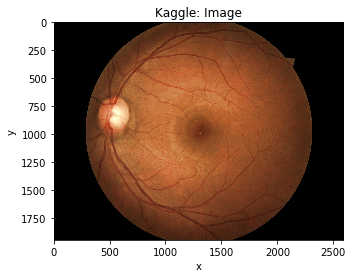

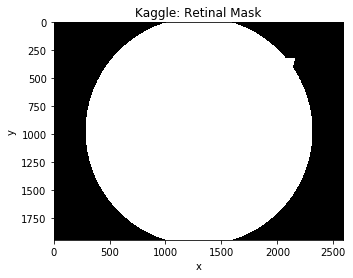

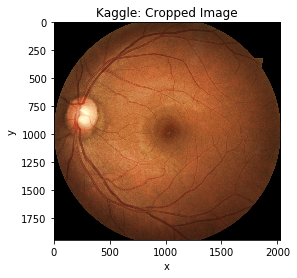

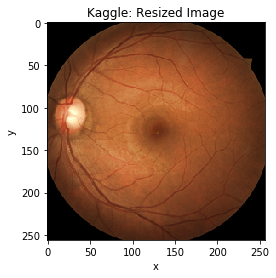

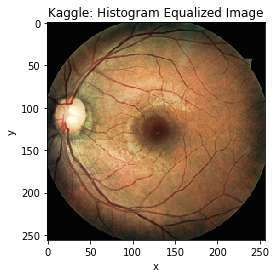

In [20]:
FilePath_im = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/Kaggle/images/13_left.jpeg'
preprocessed_image = Preprocessing(FilePathImage = FilePath_im, DesiredSize = image_size, FilePathAnnotation = None, selectchannel = None, Plot = True, DataBase = 'Kaggle')